In [757]:
!pip install missingno
!pip install openturns

In [67]:
import os
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
#df = pd.read_csv('car_insurance_claim.csv')
df = pd.read_pickle('car_insurance_ready.pkl')
stare_df = pd.read_pickle('car_insurance_ready.pkl')
df.describe()

,ID,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CLM_AMT,CAR_AGE
count,1.030200e+04,10302.000000,10295.000000,10302.000000,9754.000000,9732.000000,9727.000000,10302.000000,10302.000000,10302.000000,10302.000000,10302.000000,10302.000000,10302.000000,9663.000000
mean,4.956631e+08,0.169288,44.837397,0.720443,10.474062,61572.136719,154522.828125,33.416424,15659.952148,5.329159,4033.982422,0.800718,1.710153,1511.266479,8.298768
std,2.864675e+08,0.506512,8.606445,1.116323,4.108943,47457.460938,129186.617188,15.869687,8428.759766,4.110795,8733.081055,1.154079,2.159015,4725.114258,5.713548
min,6.317500e+04,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.442869e+08,0.000000,39.000000,0.000000,9.000000,27584.000000,0.000000,22.000000,9200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,4.970043e+08,0.000000,45.000000,0.000000,11.000000,53529.000000,160661.000000,33.000000,14400.000000,4.000000,0.000000,0.000000,1.000000,0.000000,8.000000
75%,7.394551e+08,0.000000,51.000000,1.000000,13.000000,86166.000000,238256.000000,44.000000,20890.000000,7.000000,4647.500000,2.000000,3.000000,1144.750000,12.000000
max,9.999264e+08,4.000000,81.000000,5.000000,23.000000,367030.000000,885282.000000,142.000000,69740.000000,25.000000,57037.000000,5.000000,13.000000,123247.000000,28.000000


In [68]:
df.head()

,ID,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,60.0,0,11.0,67349.0,False,0.0,False,M,...,Minivan,True,4461.0,2,False,3,0.0,18.0,False,Highly Urban/ Urban
1,132761049,0,43.0,0,11.0,91449.0,False,257252.0,False,M,...,Minivan,True,0.0,0,False,0,0.0,1.0,False,Highly Urban/ Urban
2,921317019,0,48.0,0,11.0,52881.0,False,0.0,False,M,...,Van,True,0.0,0,False,2,0.0,10.0,False,Highly Urban/ Urban
3,727598473,0,35.0,1,10.0,16039.0,False,124191.0,True,F,...,SUV,False,38690.0,2,False,3,0.0,10.0,False,Highly Urban/ Urban
4,450221861,0,51.0,0,14.0,NaN,False,306251.0,True,M,...,Minivan,True,0.0,0,False,0,0.0,6.0,False,Highly Urban/ Urban


### Braki

Na początek sprawdźmy, ile jest braków w naszych danych:

In [69]:
df.isnull().sum()

ID              0
KIDSDRIV        0
AGE             7
HOMEKIDS        0
YOJ           548
INCOME        570
PARENT1         0
HOME_VAL      575
MSTATUS         0
GENDER          0
EDUCATION       0
OCCUPATION    665
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CLM_AMT         0
CAR_AGE       639
CLAIM_FLAG      0
URBANICITY      0
dtype: int64

## Flogowanie wierszy z brakami

Imputację braków danych zaczniemy od oflagowania wierszy, w których występują jakieś braki. Wprowadzamy dodatkową kolumnę, która ma pokazywać, czy dane w tym wierszu pochodzą z oryginalnego źródła, czy są (na ten moment: będą) wynikiem imputacji. Wprowadzamy w tym celu nową zmienna - OG_data. Dla wierszy, w których braków nigdy nie było, przyjmować będzie wartość **1**, natomiast dla tych, w których imputacja była potrzebna - wartość **0**.

In [70]:
OG_data = np.where(df.notna().all(axis=1),1,0) # flagowanie braków: 0 = były braki, 1 = dane oryginalne w całym wierszu
df.insert(26,'OG_DATA', OG_data)

## Mapa korelacji pomiędzy zmiennymi zawierających braki przed imputacją

<AxesSubplot:>

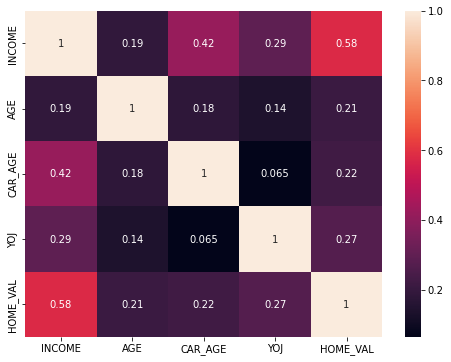

In [145]:
korelacja_stara = pd.DataFrame()
columns=['INCOME','AGE','CAR_AGE','YOJ','OCCUPATION','HOME_VAL']
for column in columns:
    korelacja_stara[column] = stare_df[column]

import seaborn as sb
f, ax = plt.subplots(figsize=(8, 6))
stare_corr = korelacja_stara.corr()
sb.heatmap(stare_corr, annot=True)

### Typy braków

Najpierw musimy określić, jakiego typu są nasze braki - MAR, MCAR czy MNAR. W tym celu obejrzyjmy wizualizajcę naszych braków:

<AxesSubplot:>

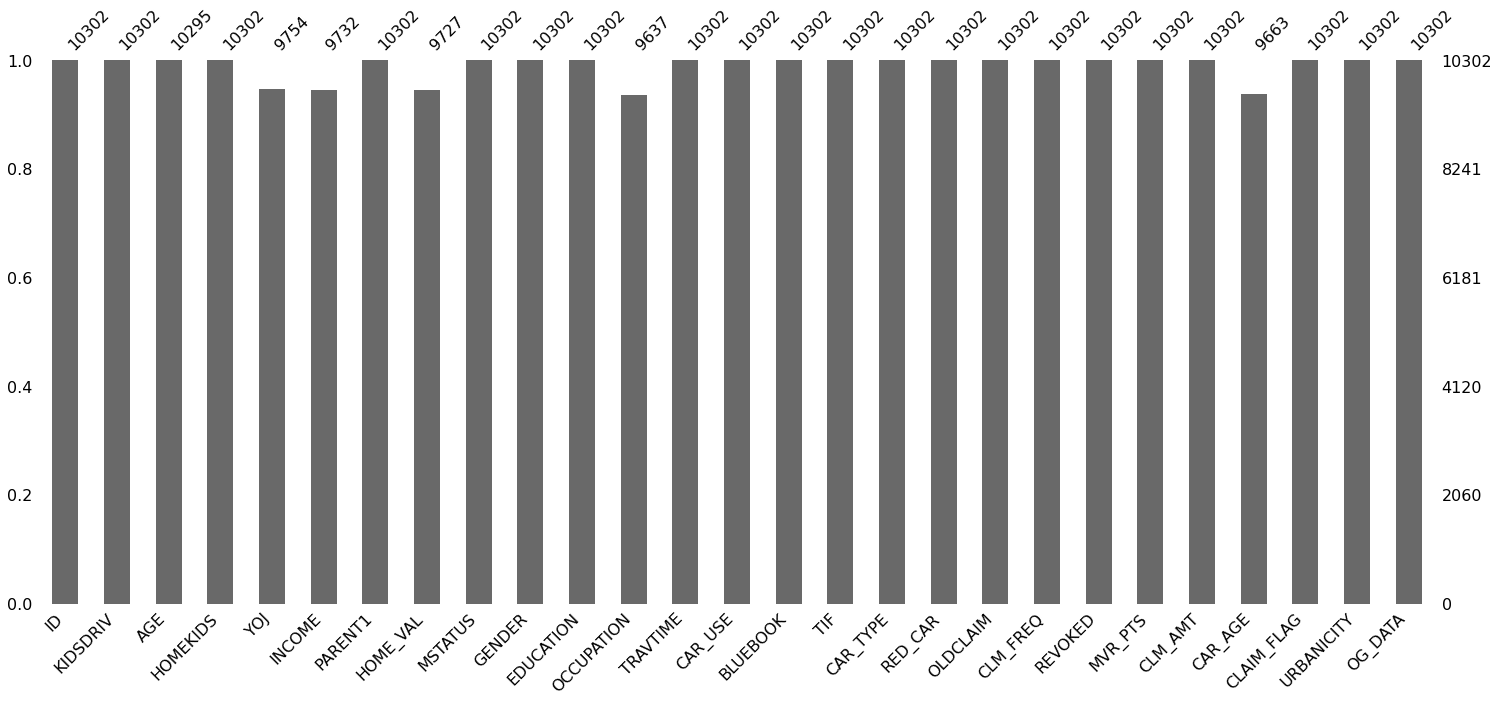

In [72]:
msno.bar(df)

Powyższa wizualizacja pokazuje stosunek ilości braków do ilości pełnych danych. Widać tu, że braków mamy niewiele w porównaniu z ilością wierszy.

ID
KIDSDRIV
AGE
HOMEKIDS
YOJ
INCOME
PARENT1
HOME_VAL
MSTATUS
GENDER
EDUCATION
OCCUPATION
TRAVTIME
CAR_USE
BLUEBOOK
TIF
CAR_TYPE
RED_CAR
OLDCLAIM
CLM_FREQ
REVOKED
MVR_PTS


C:\Users\lnaklicki001\Documents\Anaconda\lib\site-packages\missingno\missingno.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


CLM_AMT
CAR_AGE
CLAIM_FLAG
URBANICITY
OG_DATA


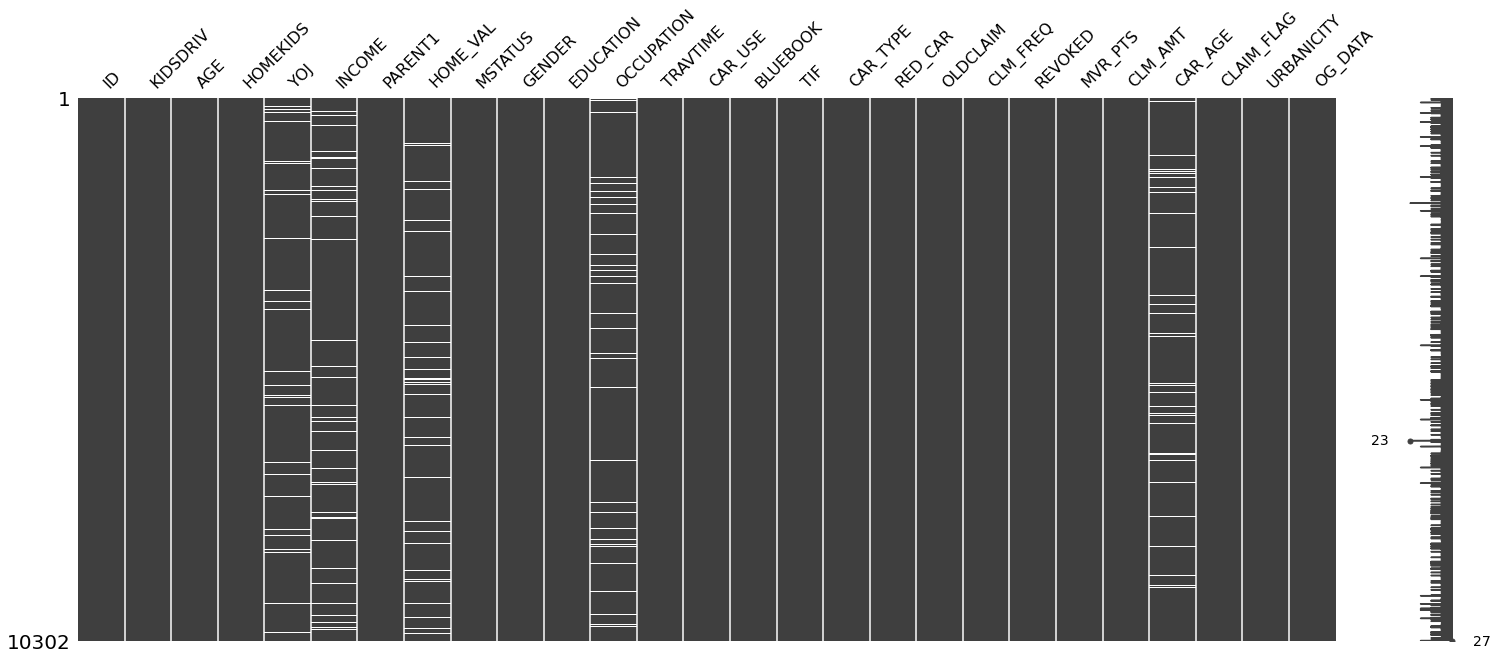

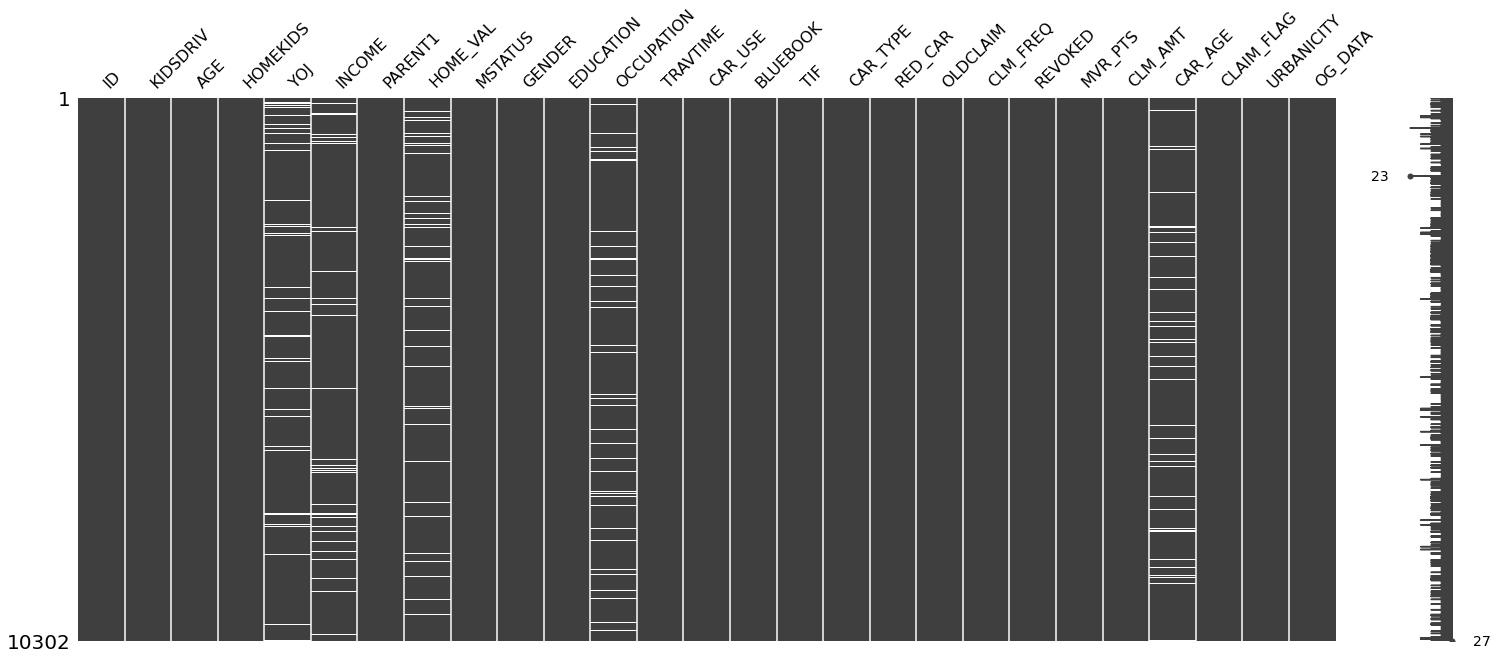

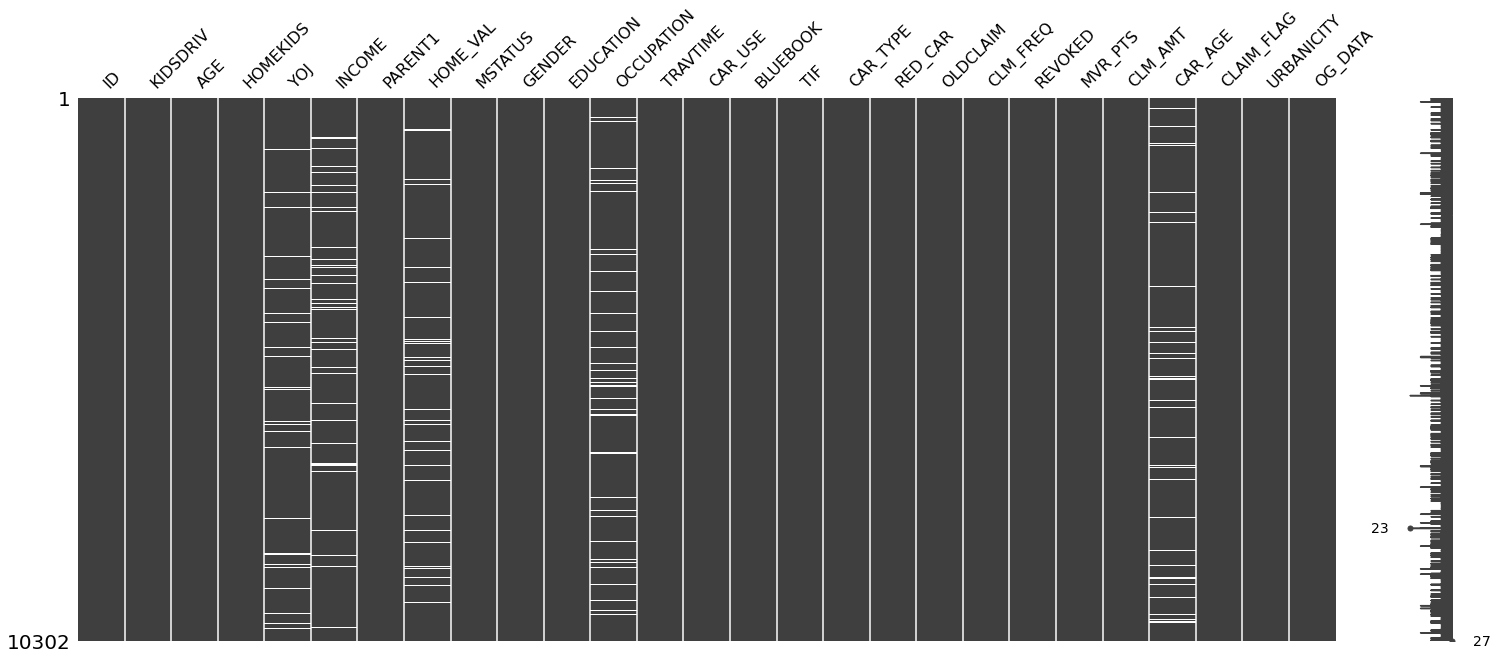

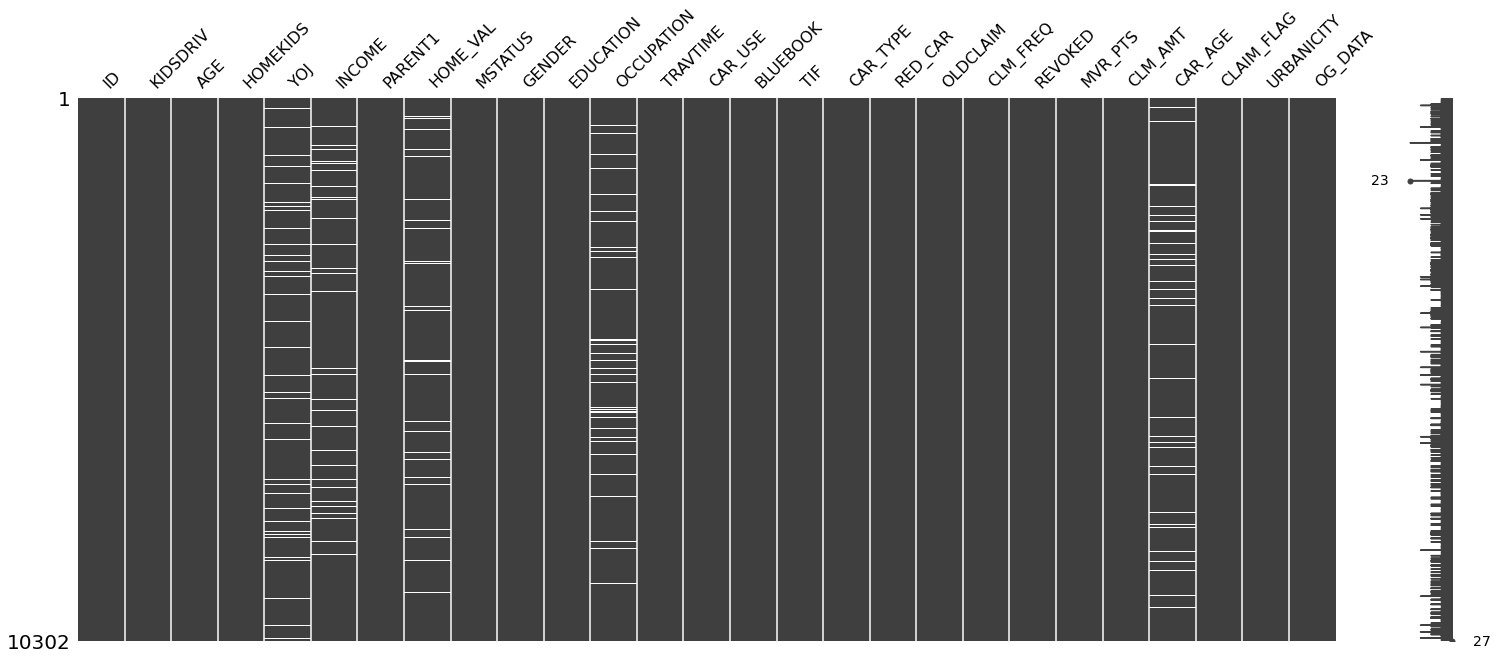

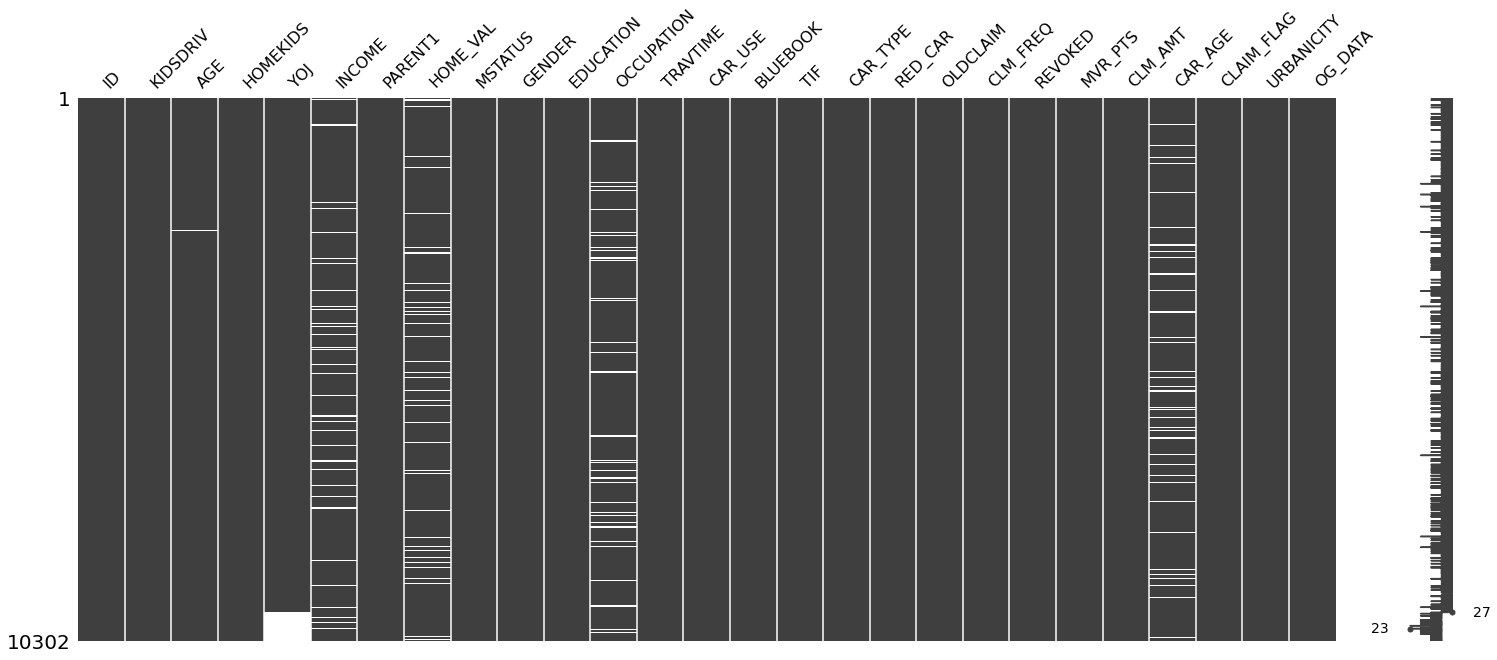

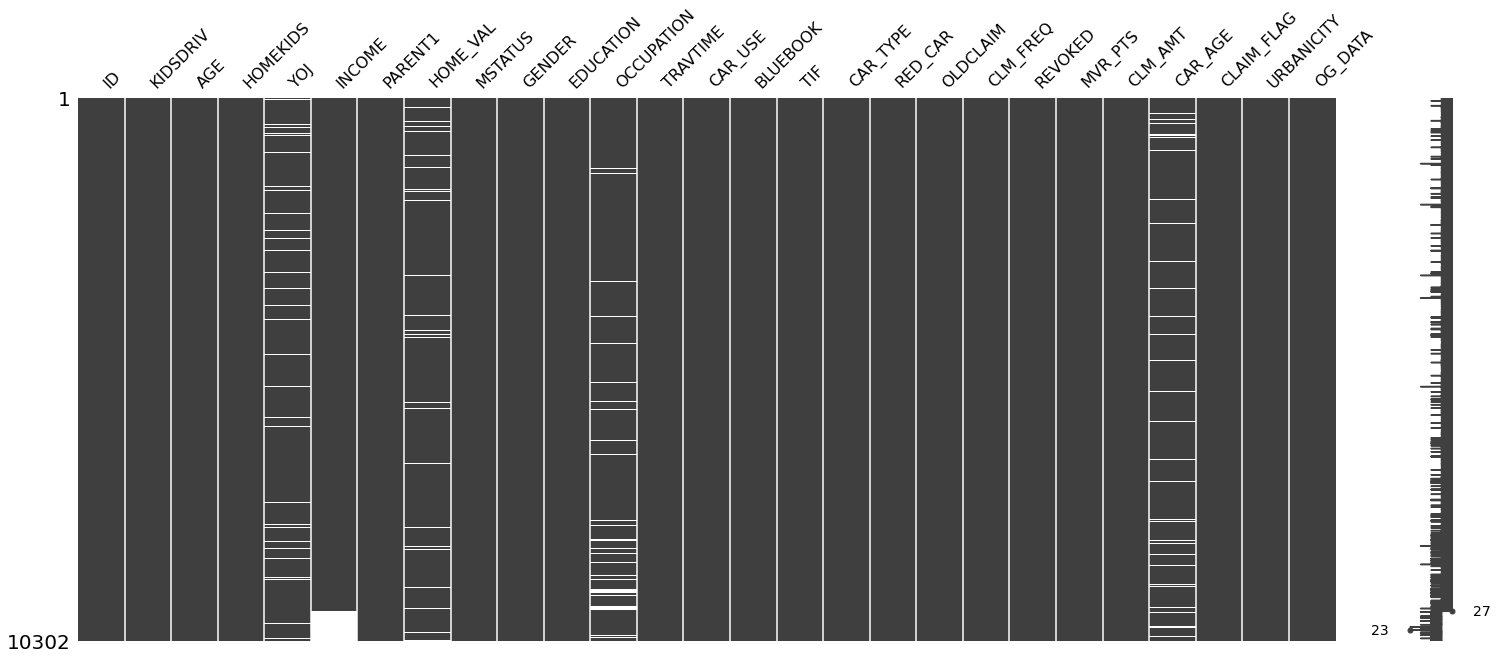

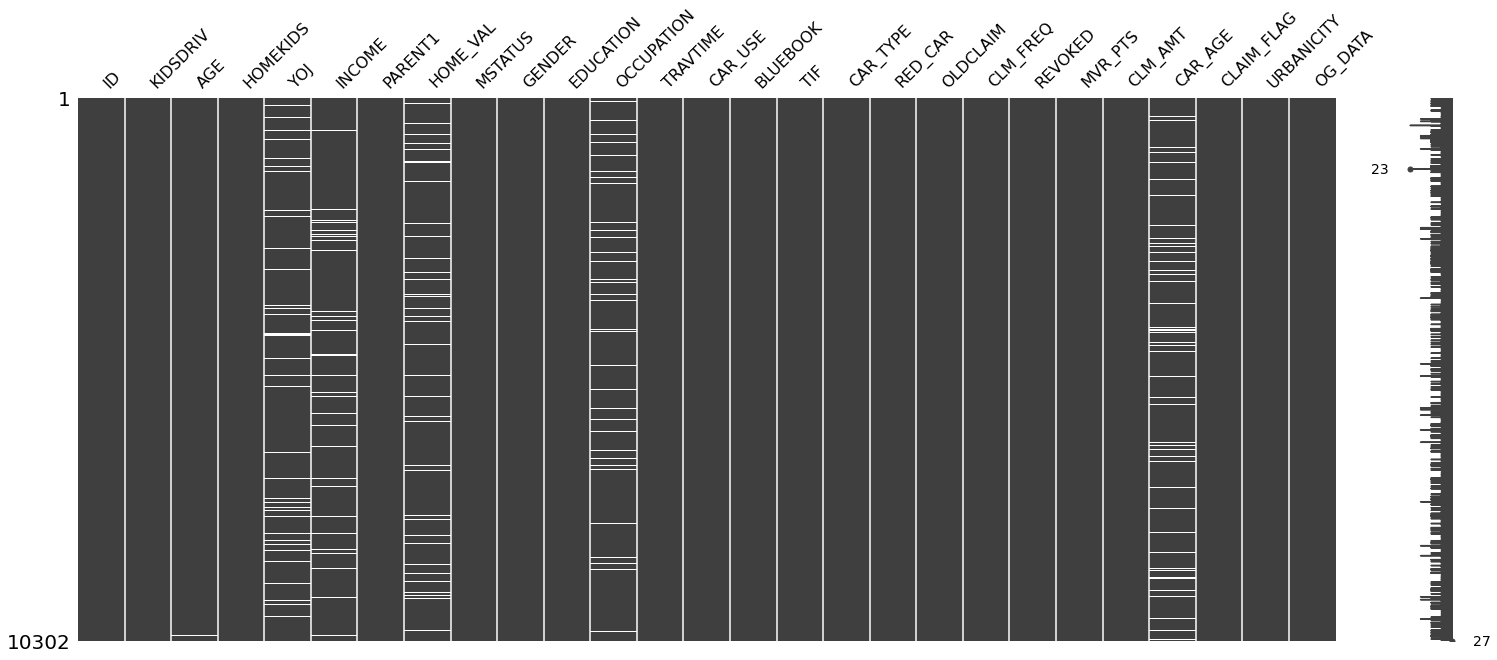

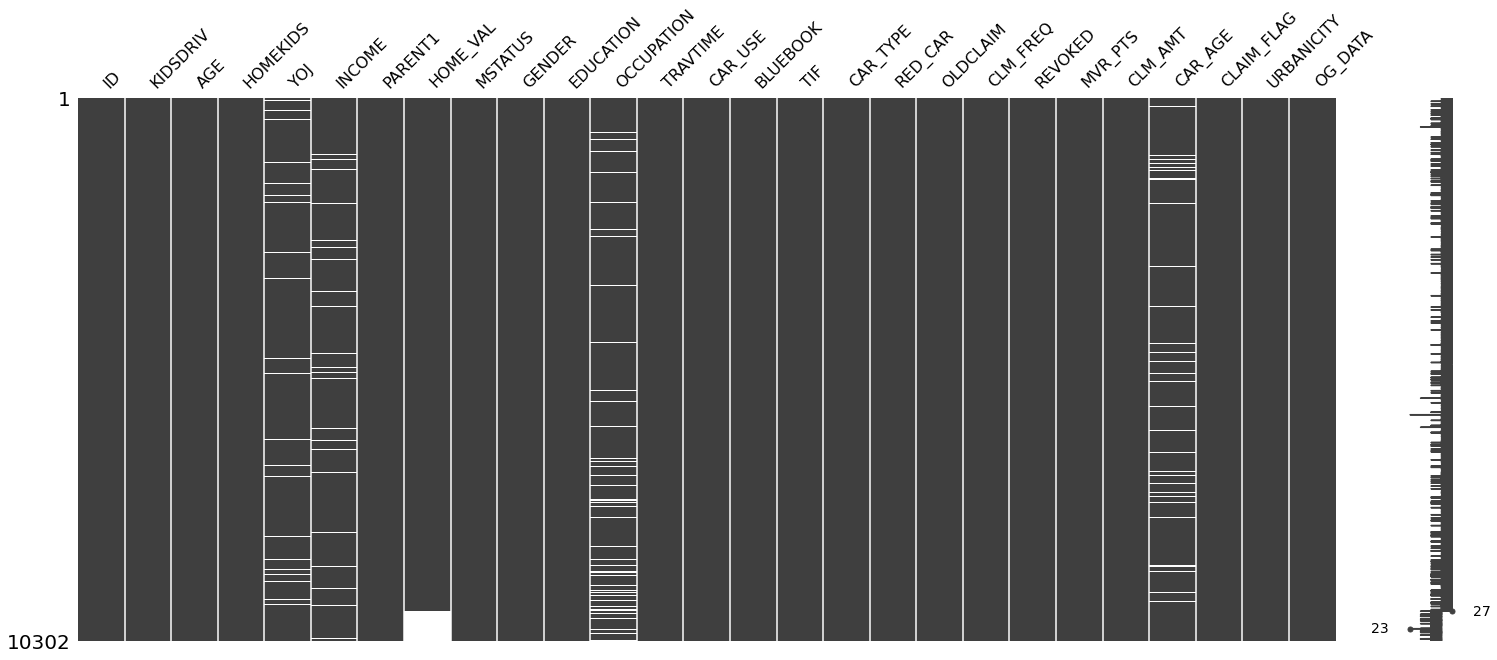

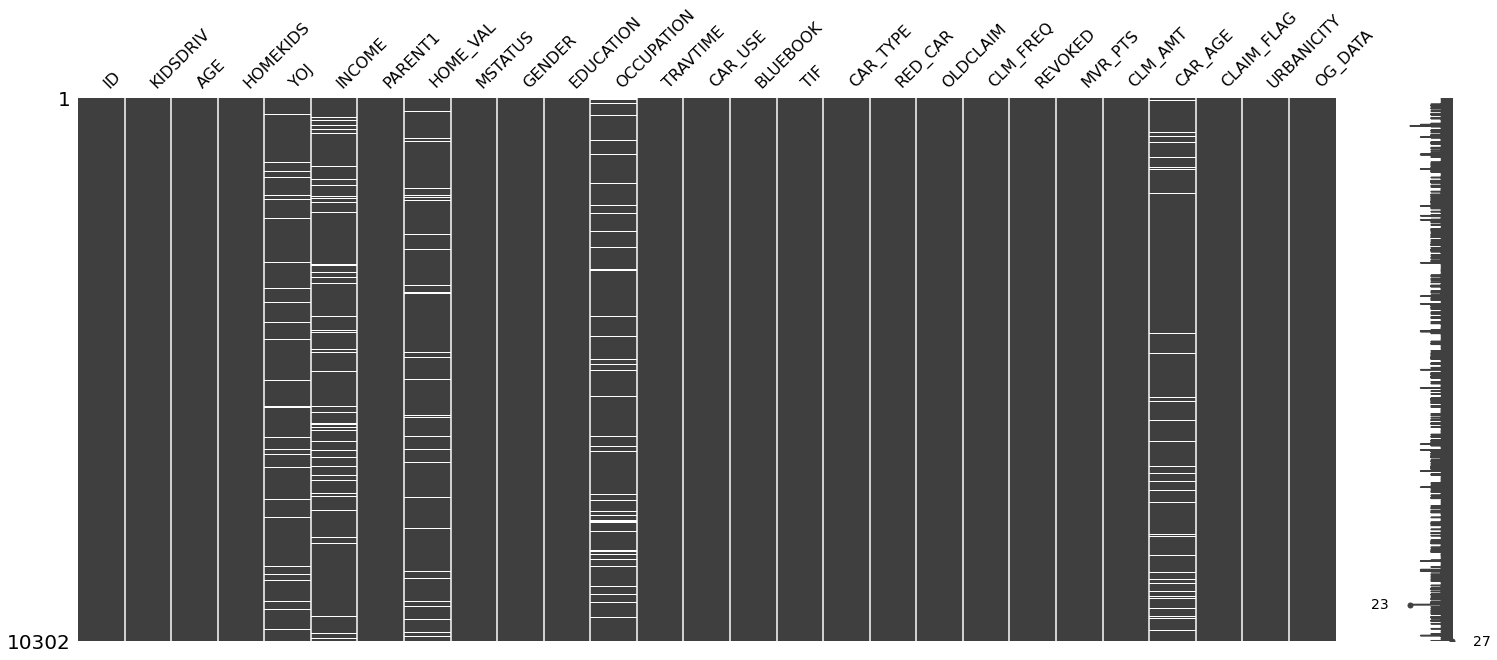

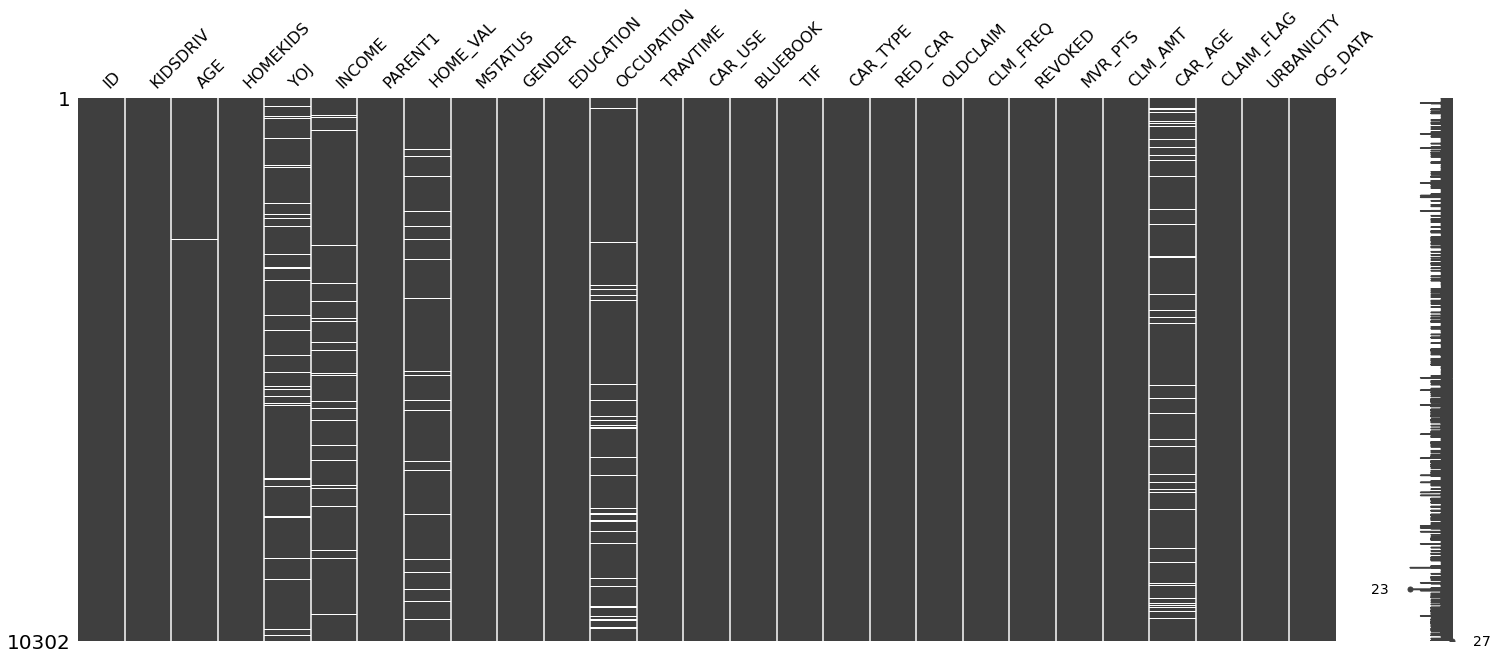

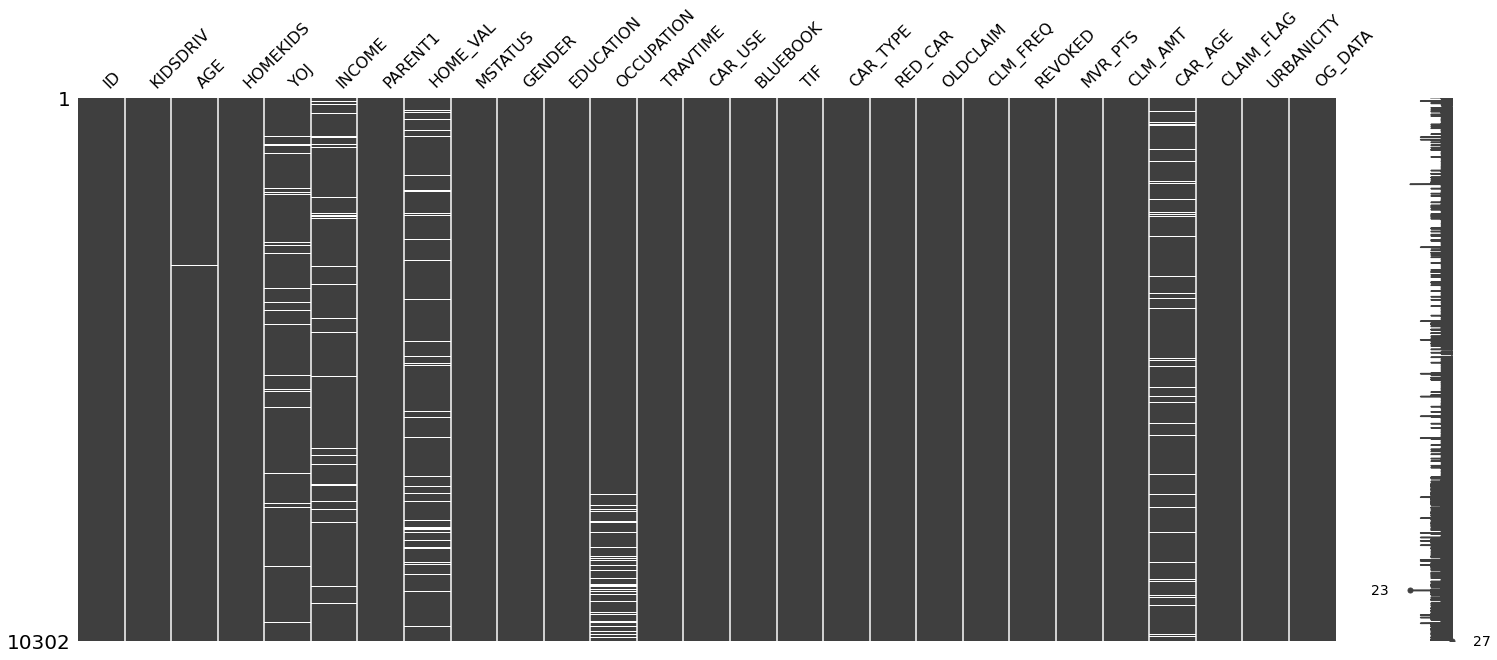

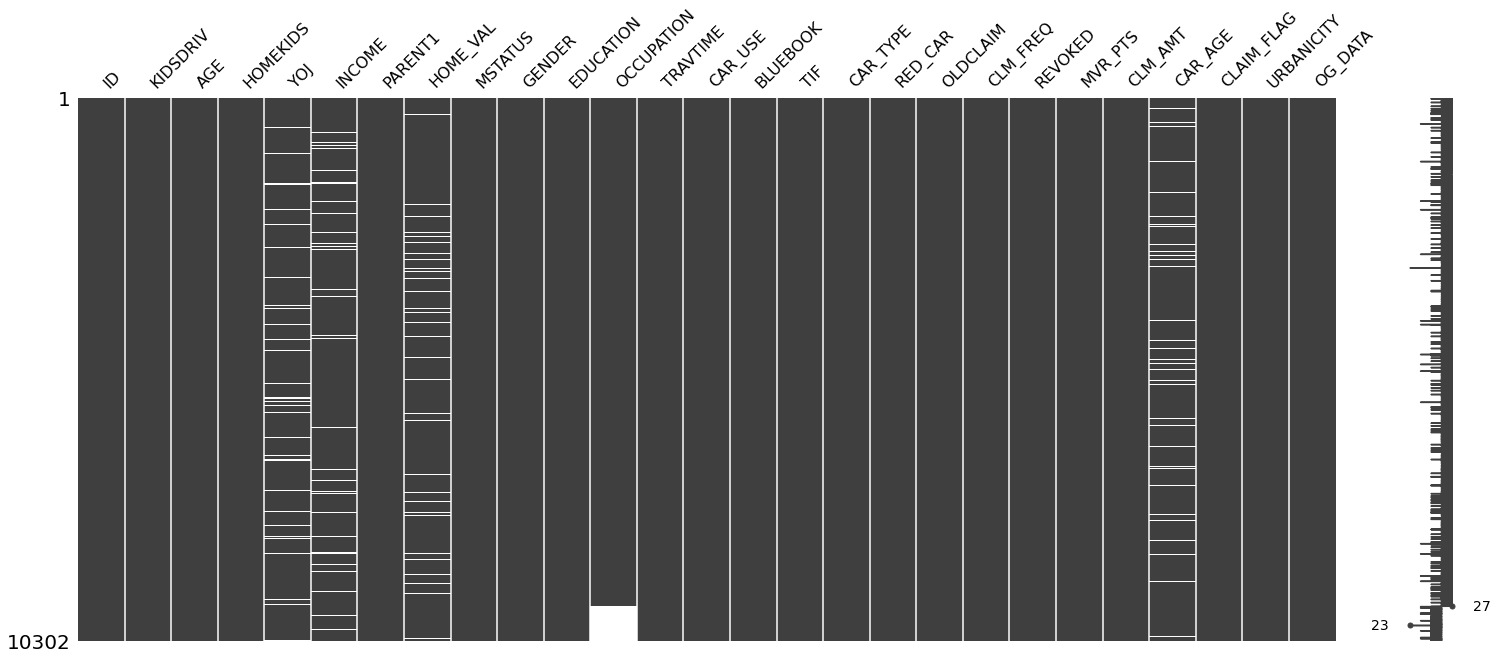

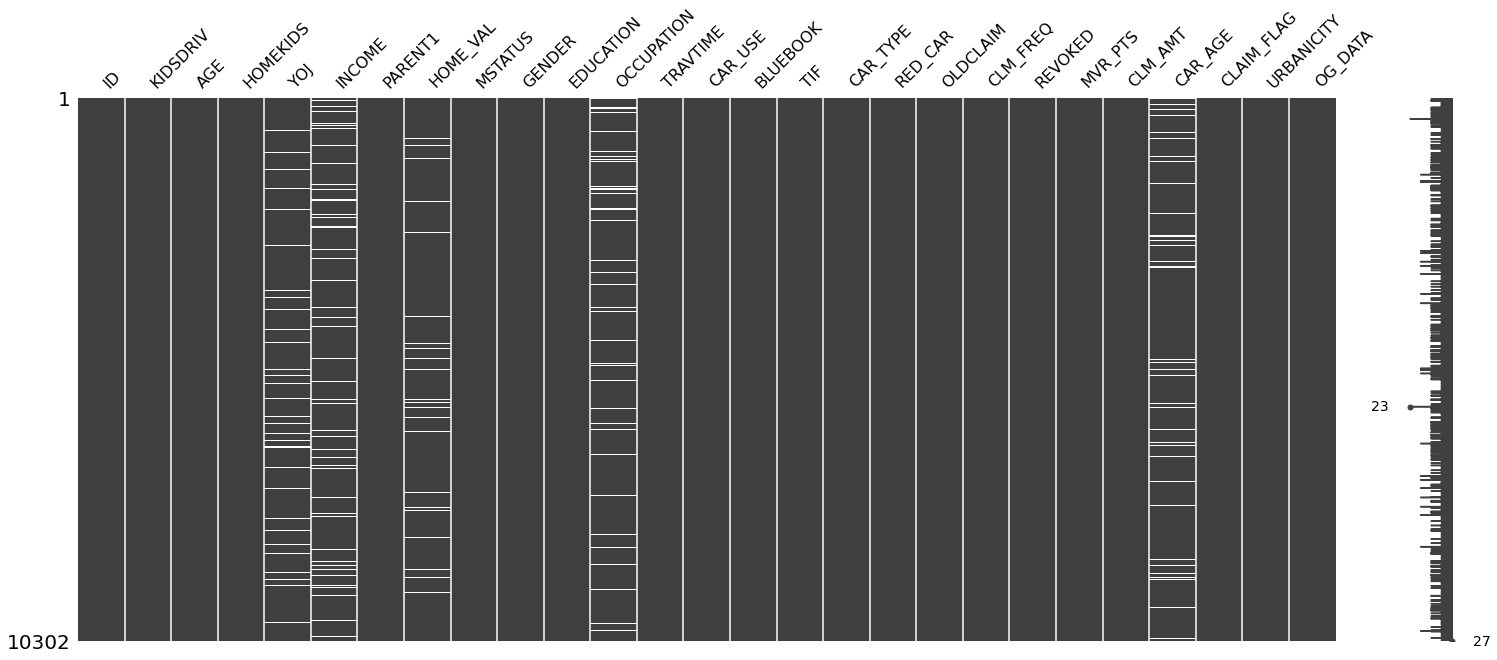

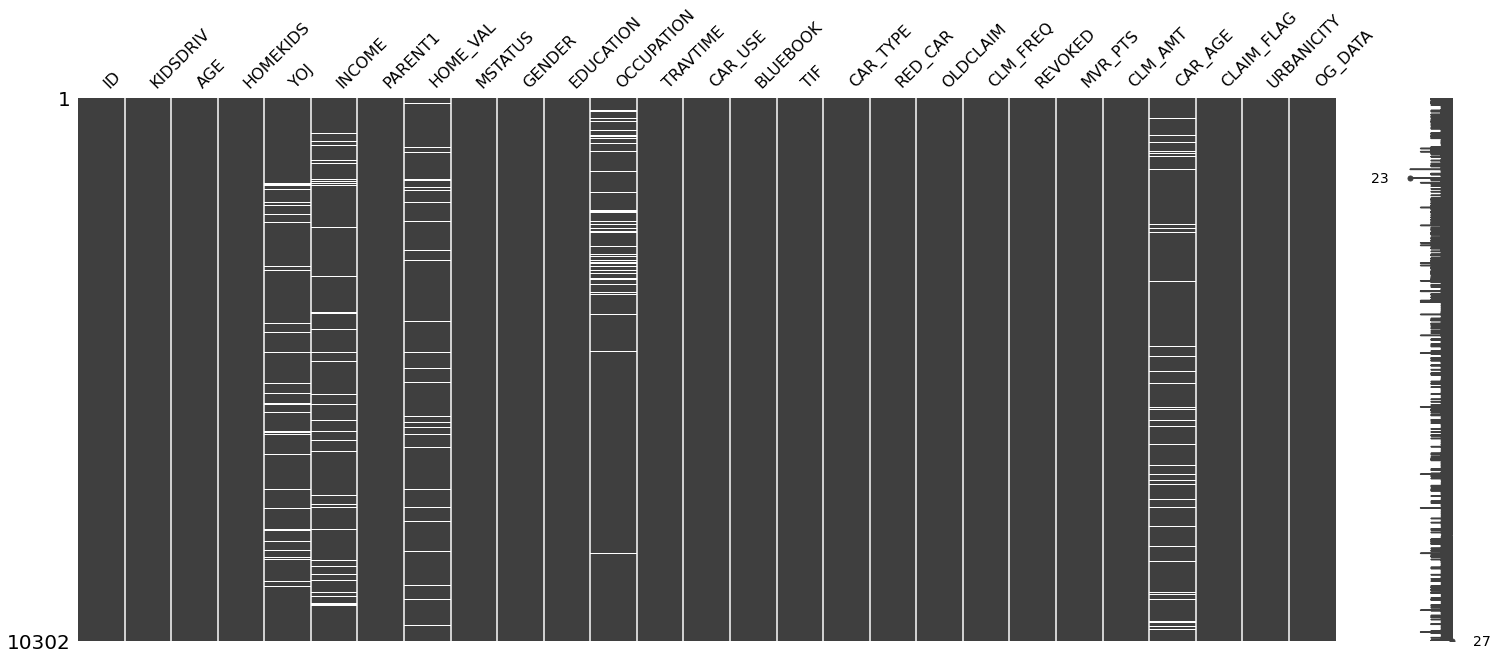

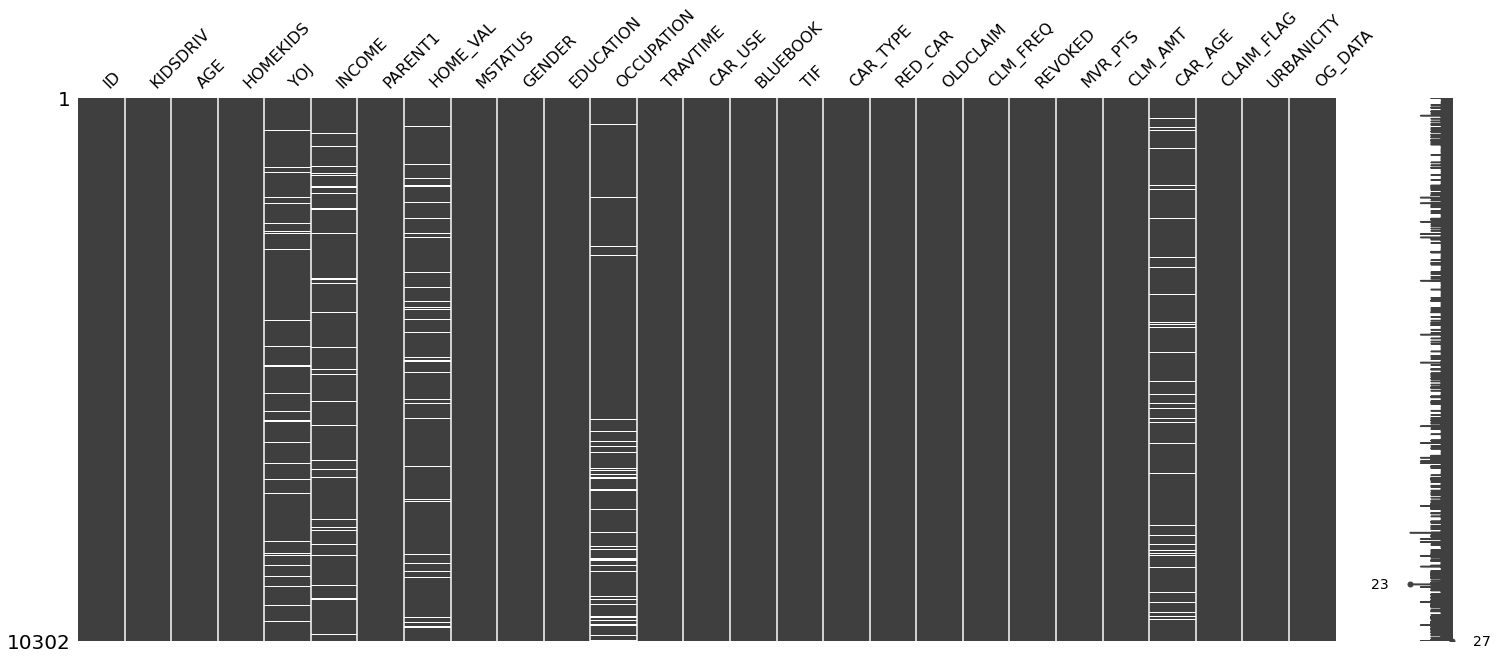

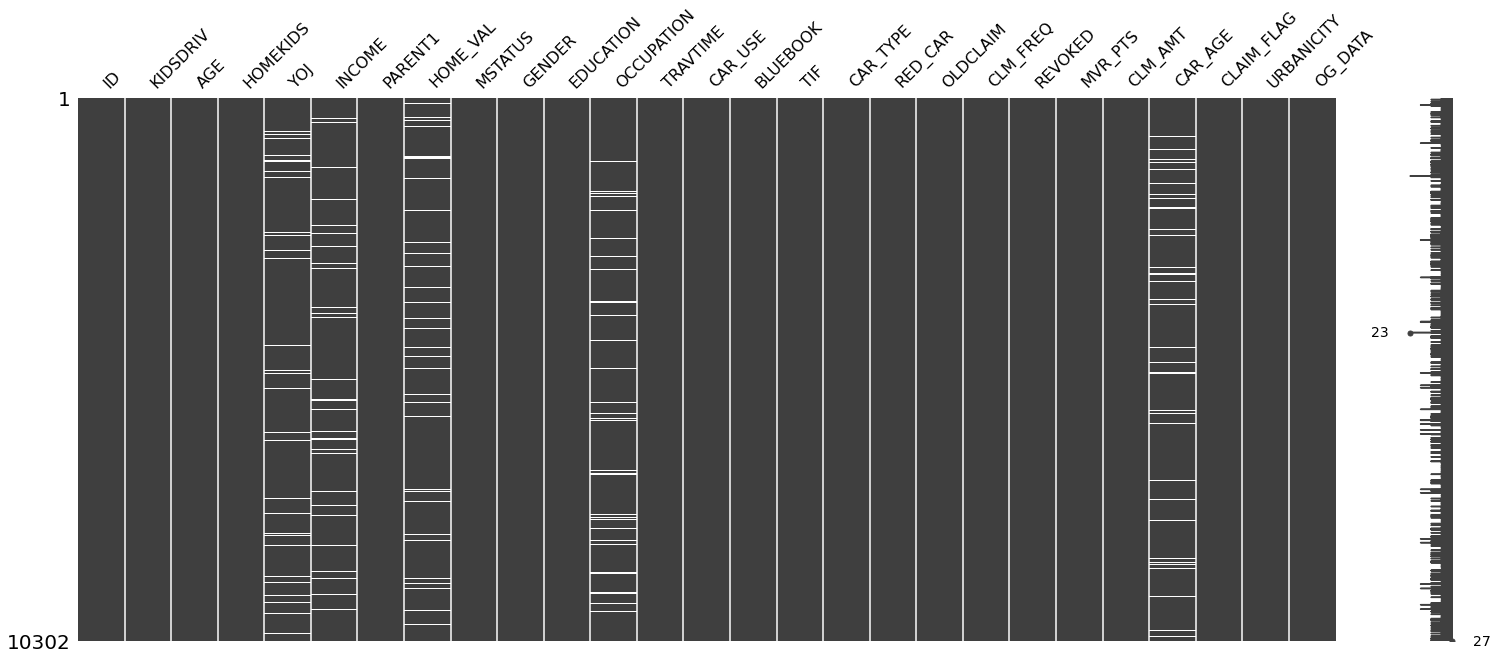

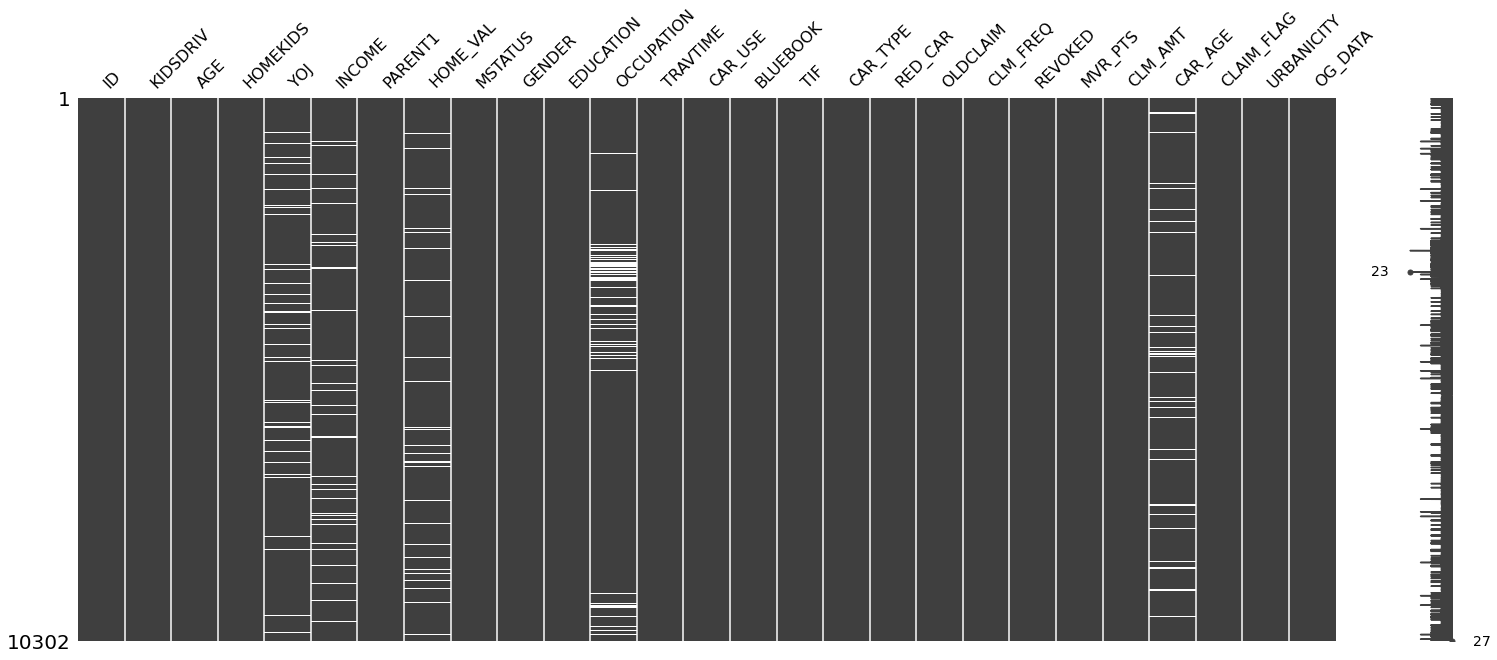

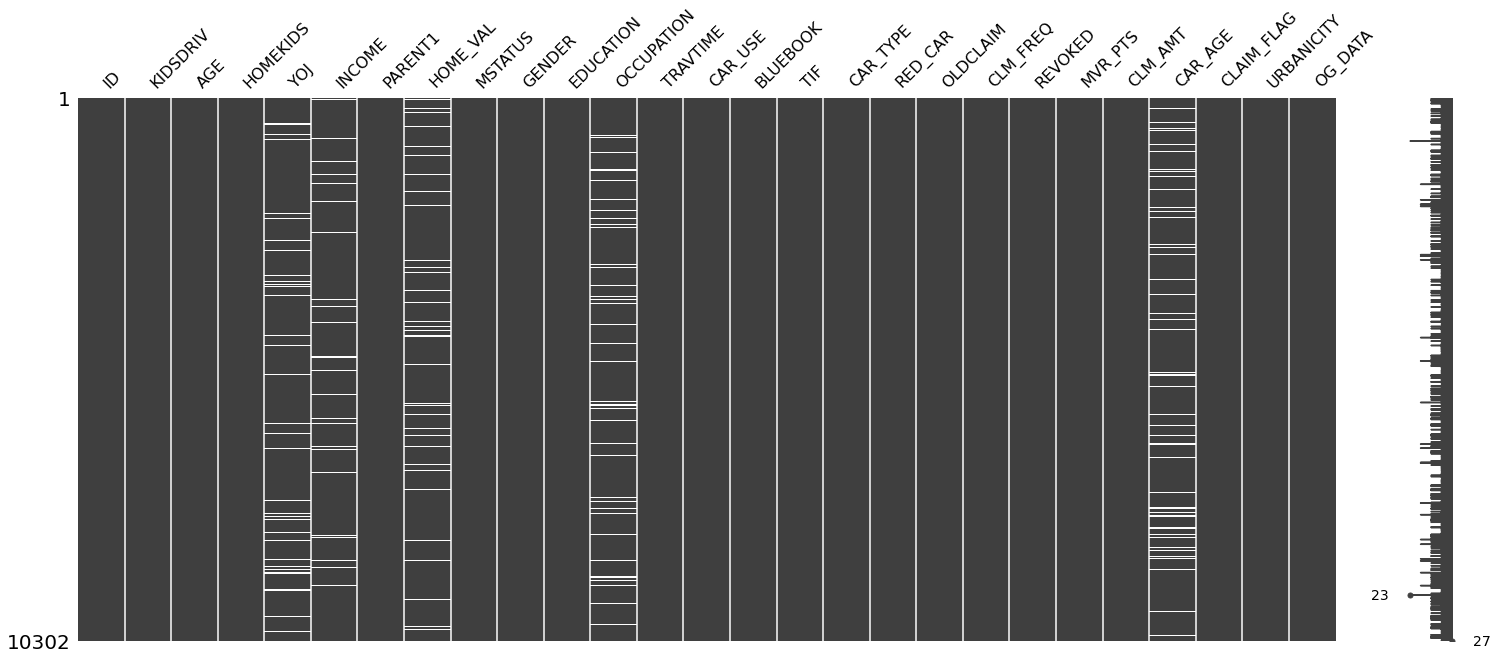

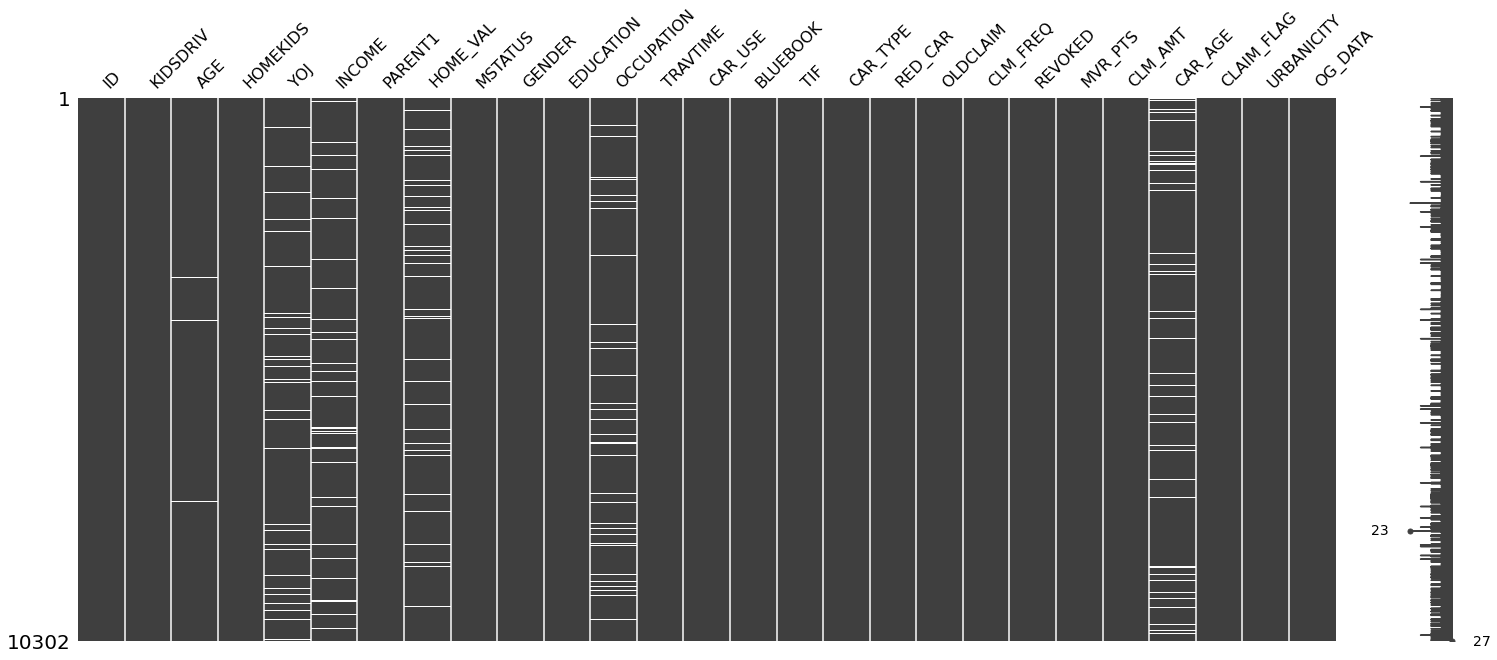

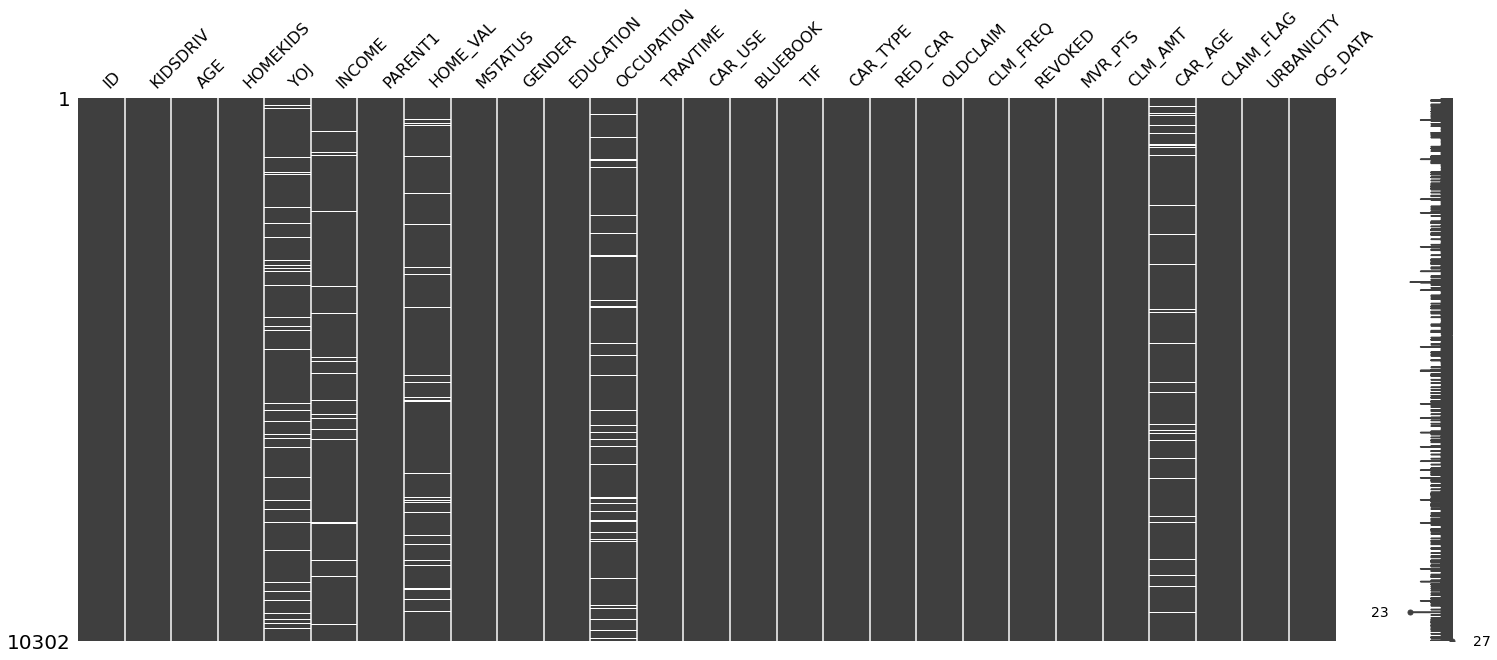

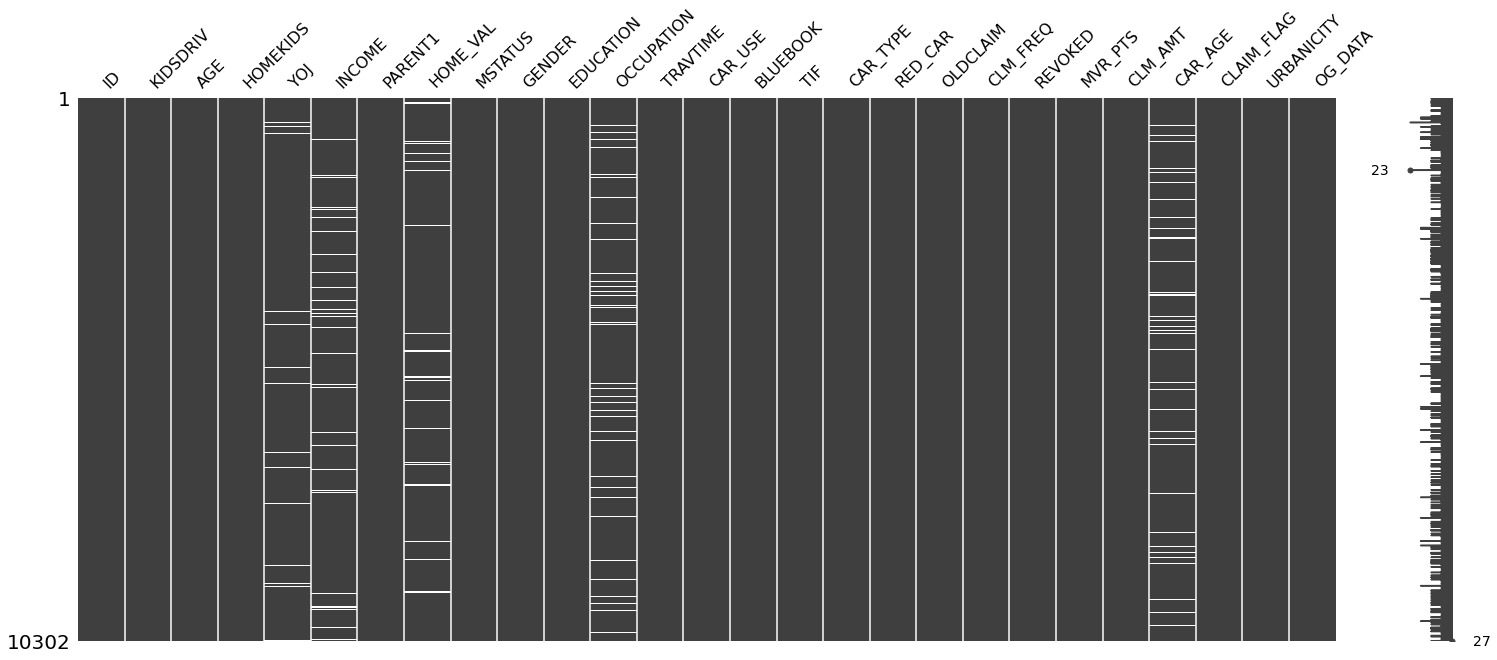

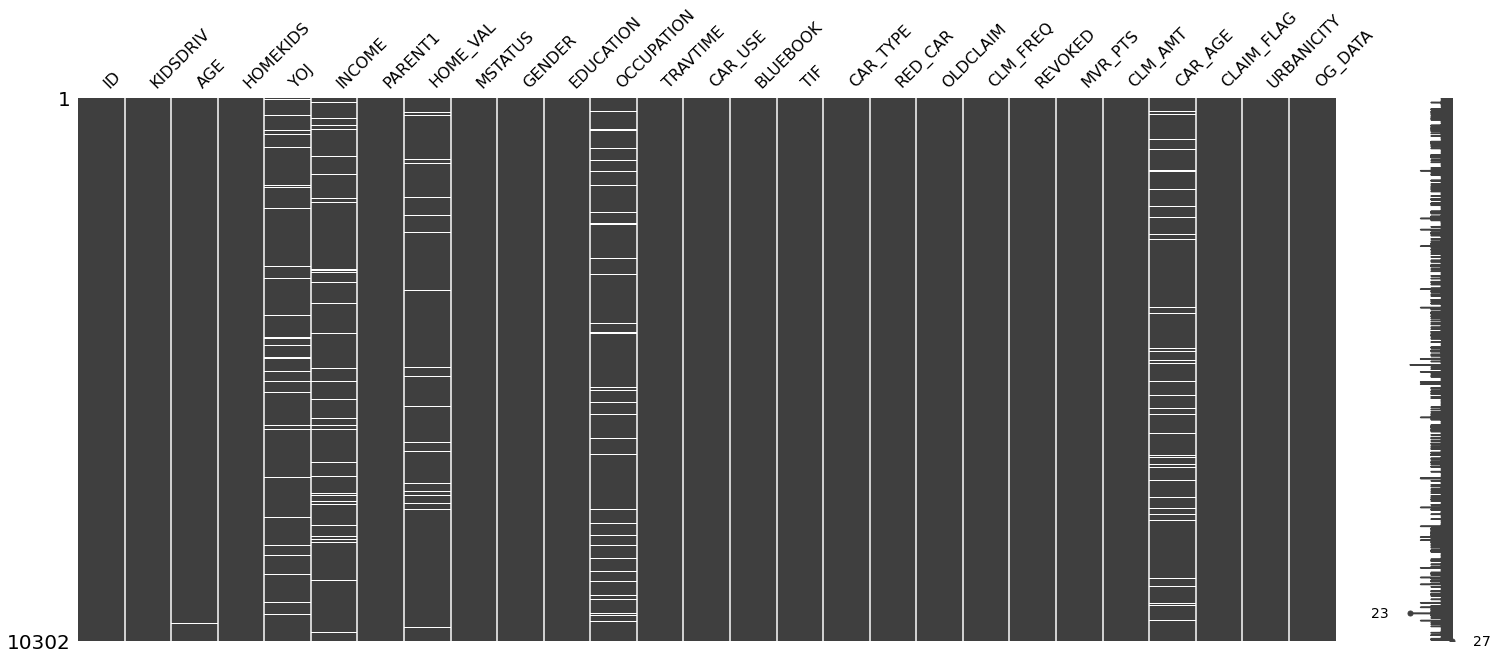

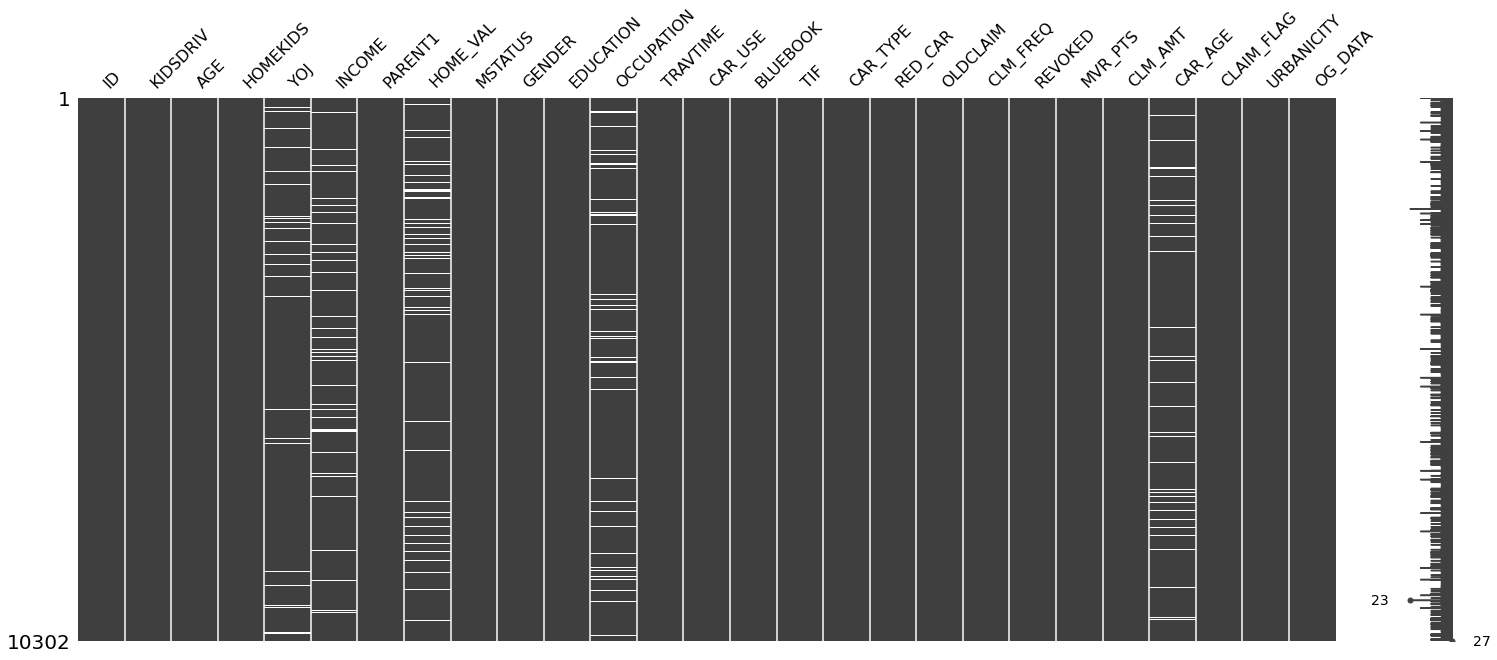

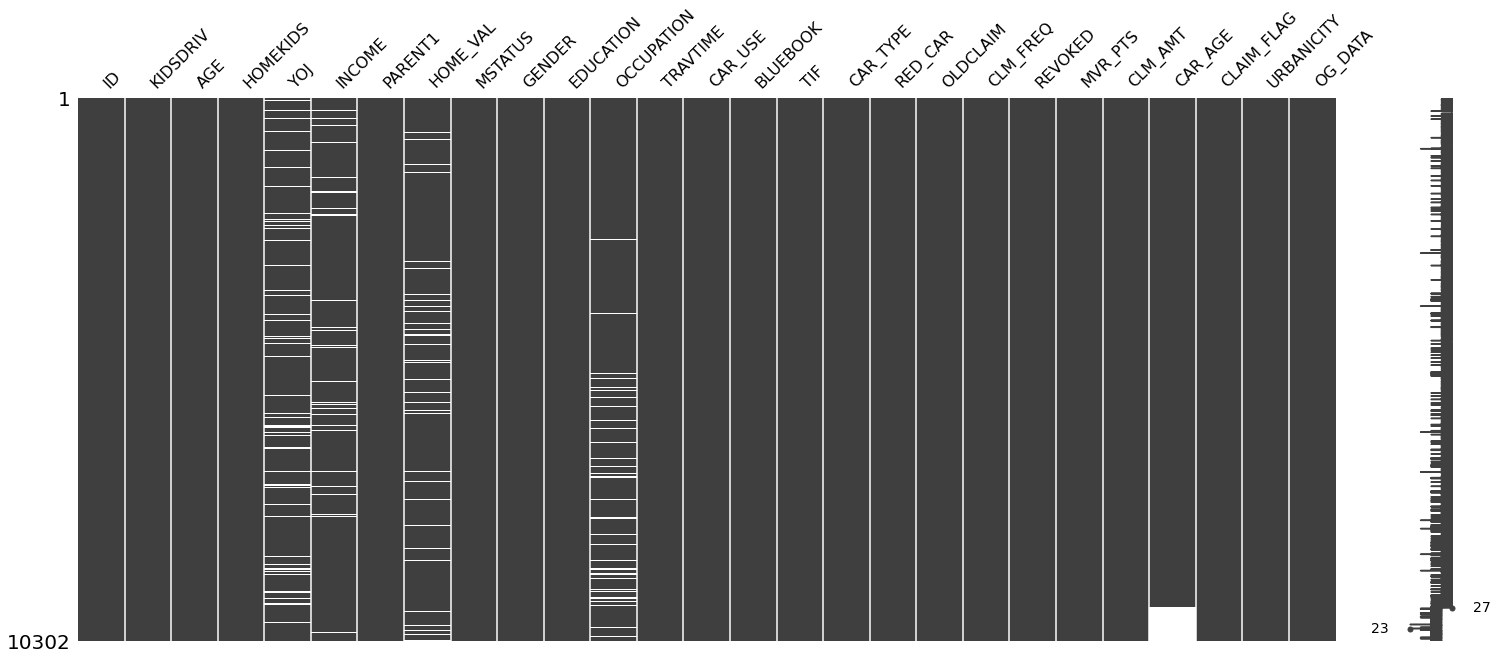

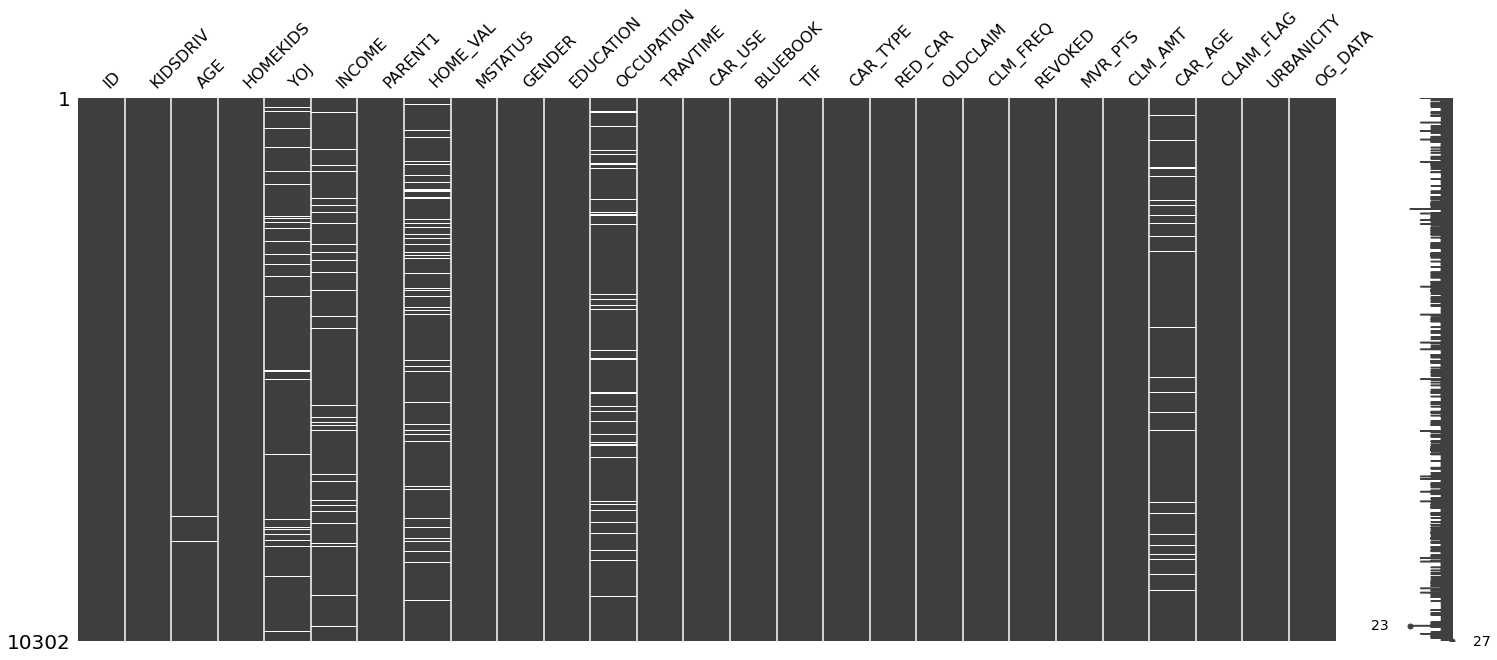

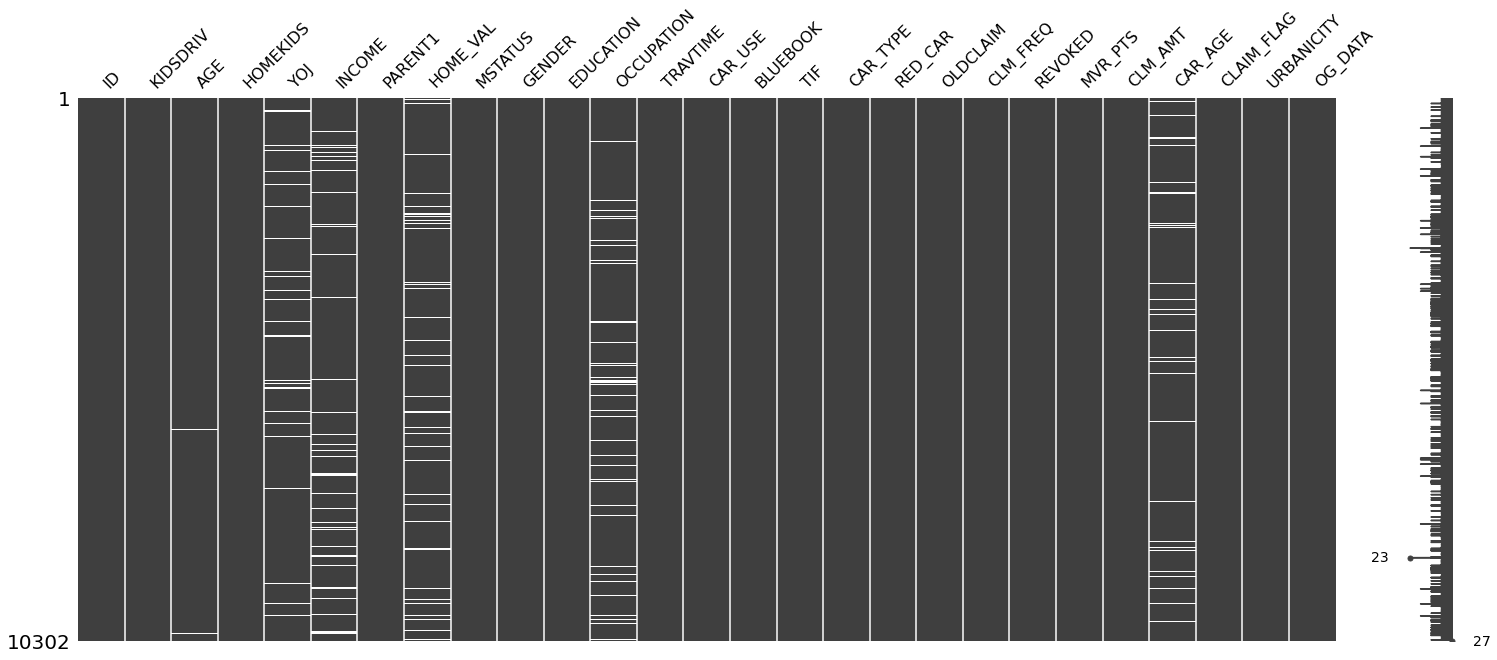

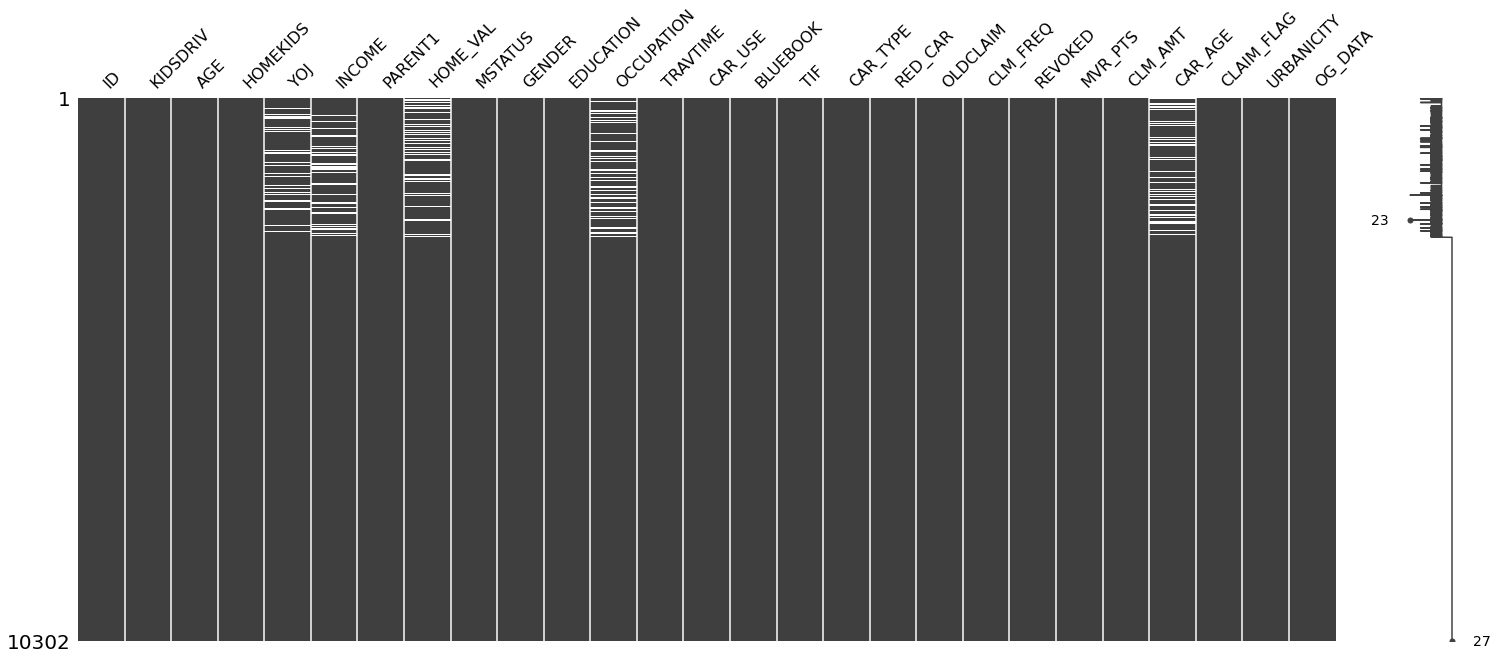

In [73]:
for column in df.columns:
    print(column)
    msno.matrix(df.sort_values(by=column))

Powyższe wykresy sugerują, że braki zmiennych są zupełnie losowe. Pewne wątpliwości nasuwają się jedynie w przypadku zmiennej OCCUPATION (braki mogą mieć związek z wyższym wykształceniem i faktem wykorzystywania samochodu w celach służbowych oraz rodzajem używanego samochodu). Jest to jednak zmienna jakościowa, dlatego nie można na podstawie tego wykresu wykluczyć losowości.

<AxesSubplot:>

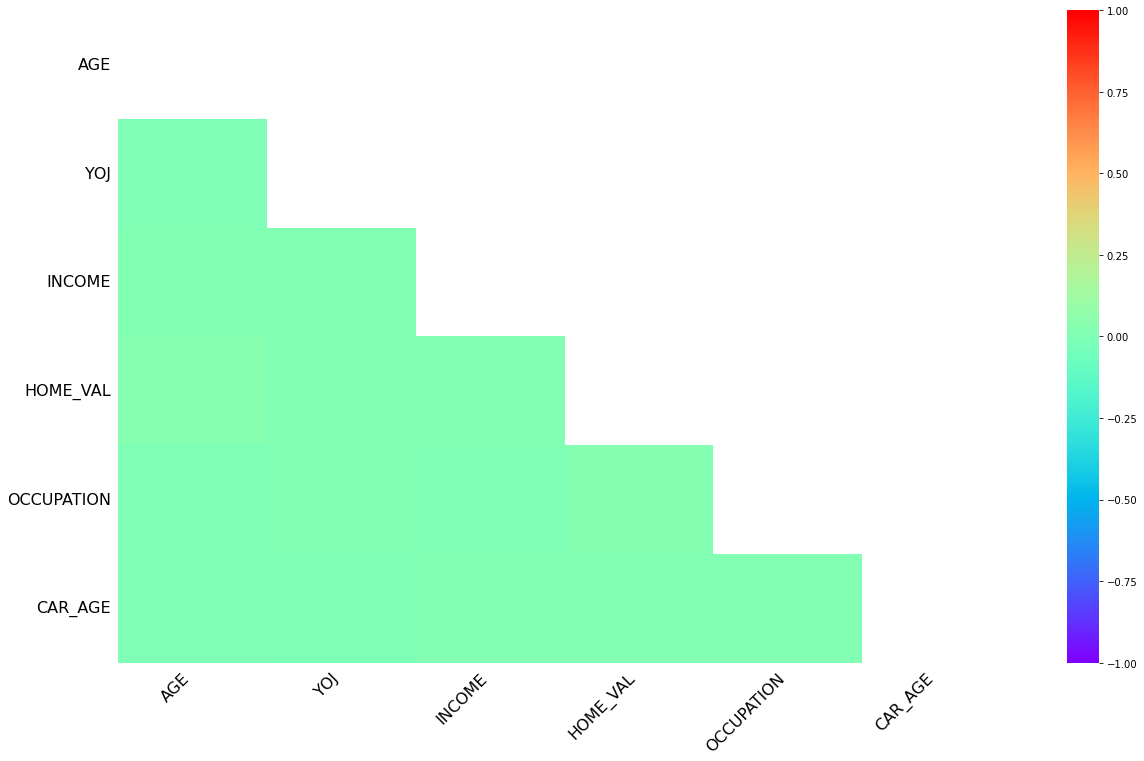

In [74]:
msno.heatmap(df, cmap='rainbow')

Heatmapa wyraźnie pokazuje brak jakiejkolwiek korelacji pomiędzy brakami danych. To również mocno sugeruje losowość braków danych. Biorąc to wszystko pod uwagę, możena założyć, że braki są typu **MAR**.

## Wiek

Braki w zmiennej AGE nie zostaną imputowane, ponieważ w procesie eksploracji danych wywnioskowano, że braki oznaczają błędne rekordy, zatem wiersze z brakiem wartości zmiennej AGE zostaną ze zbioru danych usunięte.

In [85]:
df = df.dropna(subset=['AGE'])
df = df.reset_index(drop=True)

In [86]:
df.isnull().sum()

ID              0
KIDSDRIV        0
AGE             0
HOMEKIDS        0
YOJ           548
INCOME        569
PARENT1         0
HOME_VAL      573
MSTATUS         0
GENDER          0
EDUCATION       0
OCCUPATION    665
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CLM_AMT         0
CAR_AGE       639
CLAIM_FLAG      0
URBANICITY      0
OG_DATA         0
dtype: int64

## Imputacja brakujących danych metodą KNN

In [87]:
df.isnull().sum()

ID              0
KIDSDRIV        0
AGE             0
HOMEKIDS        0
YOJ           548
INCOME        569
PARENT1         0
HOME_VAL      573
MSTATUS         0
GENDER          0
EDUCATION       0
OCCUPATION    665
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CLM_AMT         0
CAR_AGE       639
CLAIM_FLAG      0
URBANICITY      0
OG_DATA         0
dtype: int64

In [88]:
from sklearn.impute import KNNImputer
imputer = KNNImputer()


liczbowe = pd.DataFrame()
for column in df.columns:
    if df[column].dtypes == 'float64' or df[column].dtypes == 'int64' or df[column].dtypes == 'float32' or df[column].dtypes == 'int32':
        copy = df[column].copy()
        liczbowe[column] = copy
    


imputed = pd.DataFrame(imputer.fit_transform(liczbowe),columns = liczbowe.columns)

for column in imputed.columns:
    df[column] = imputed[column]
    
df.isna().sum()

ID              0
KIDSDRIV        0
AGE             0
HOMEKIDS        0
YOJ             0
INCOME          0
PARENT1         0
HOME_VAL        0
MSTATUS         0
GENDER          0
EDUCATION       0
OCCUPATION    665
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CLM_AMT         0
CAR_AGE         0
CLAIM_FLAG      0
URBANICITY      0
OG_DATA         0
dtype: int64

### Zawód

Najpierw należy sprawdzić, jakie unikalne wartości przyjmuje zmienna OCCUPATION:

In [89]:
df['OCCUPATION'].unique()

['Professional', 'Blue Collar', 'Manager', 'Clerical', 'Doctor', 'Lawyer', NaN, 'Home Maker', 'Student']
Categories (8, object): ['Blue Collar', 'Clerical', 'Doctor', 'Home Maker', 'Lawyer', 'Manager', 'Professional', 'Student']

Następnie utworzyć mniejsze zestawy danych dla każdej unikalnej wartości zmiennej OCCUPATION:

In [90]:
zapasowy_df = pd.DataFrame.from_dict(df)

professional = zapasowy_df.loc[df['OCCUPATION']=='Professional']
blue_collar = zapasowy_df.loc[df['OCCUPATION']=='Blue Collar']
manager = zapasowy_df.loc[df['OCCUPATION']=='Manager']
clerical = zapasowy_df.loc[df['OCCUPATION']=='Clerical']
doctor = zapasowy_df.loc[df['OCCUPATION']=='Doctor']
lawyer = zapasowy_df.loc[df['OCCUPATION']=='Lawyer']
home_maker = zapasowy_df.loc[df['OCCUPATION']=='Home Maker']
student = zapasowy_df.loc[df['OCCUPATION']=='Student']
nan = zapasowy_df.loc[df['OCCUPATION'].isnull()]

Teraz policzyć średni INCOME dla każdego z zawodów:

In [91]:
from statistics import mean

mean_professional = mean(professional["INCOME"])
mean_blue_collar = mean(blue_collar["INCOME"])
mean_manager = mean(manager["INCOME"])
mean_clerical = mean(clerical["INCOME"])
mean_doctor = mean(doctor["INCOME"])
mean_lawyer = mean(lawyer["INCOME"])
mean_home_maker = mean(home_maker["INCOME"])
mean_student = mean(student["INCOME"])

Potem zdefiniować funkcję, która ma znaleźć najbardziej zbliżoną wartość spośród listy średnich dochodów dla wartości wprowadzonej. To wszystko po to, aby dopasować zawód do wierszy, w których zawód jest wartością brakującą, na podstawie zarobków w danym wierszu.

In [92]:
def closest_value(list, value):
    arr = np.asarray(list)
    i = (np.abs(arr - value)).argmin()
    return arr[i]

In [93]:
#zbiór średnich zarobków w danym zawodzie
means = [mean_professional, mean_blue_collar, mean_manager,
         mean_clerical, mean_doctor, mean_lawyer, mean_home_maker, mean_student]

#### Porównanie średnich zarobków w poszczególnych zawodach

In [94]:
srednie = pd.DataFrame()

srednie['MEAN'] = means
srednie['OCCUPATION'] = ['Professional', 'Blue Collar', 'Manager', 'Clerical', 'Doctor', 'Lawyer', 'Home Maker', 'Student']
srednie.sort_values(by='MEAN', ascending=False)

,MEAN,OCCUPATION
4,125102.618069,Doctor
5,87116.818817,Lawyer
2,86741.333652,Manager
0,75174.745313,Professional
1,58709.599563,Blue Collar
3,34992.050756,Clerical
6,15097.047325,Home Maker
7,9808.183259,Student


#### Rozkład zarobków w poszczególnych zawodach

##### Doctor

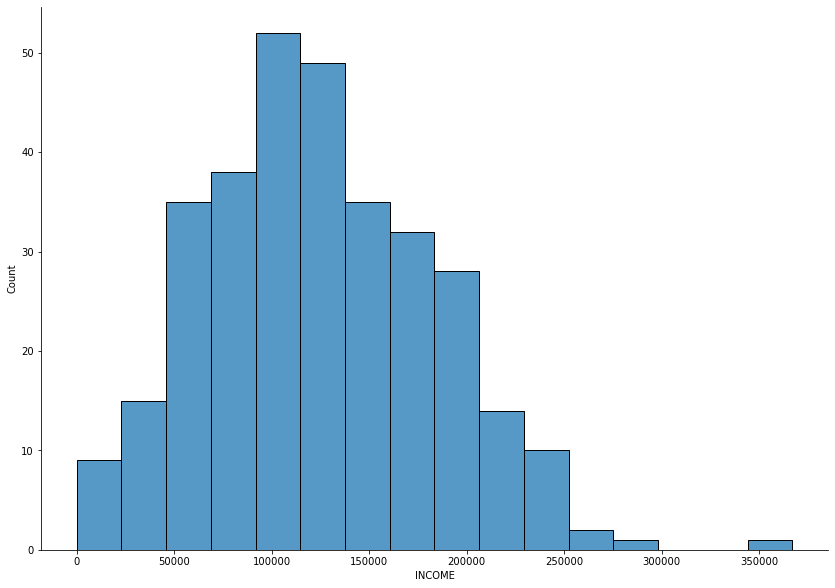

In [131]:
sb.displot(doctor, x="INCOME", height=8.27, aspect=11.7/8.27)

##### Lawyer

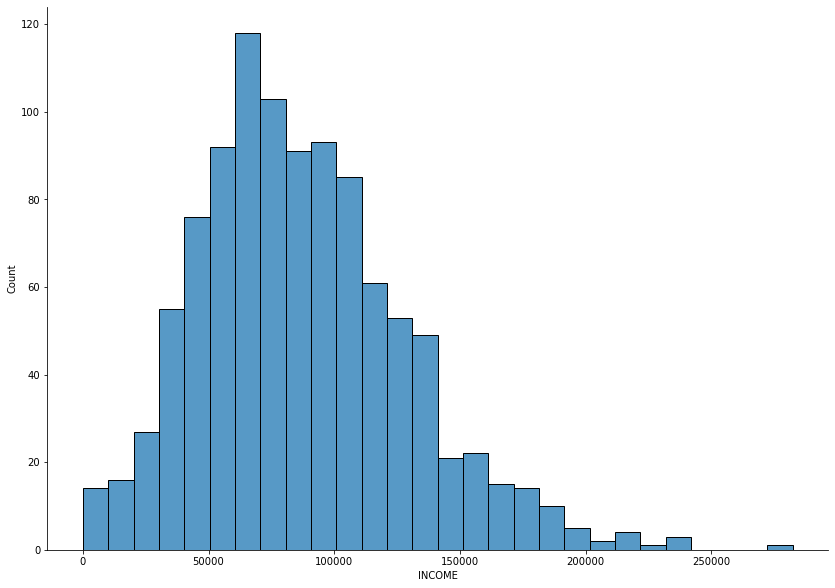

In [130]:
sb.displot(lawyer, x="INCOME", height=8.27, aspect=11.7/8.27)

##### Manager

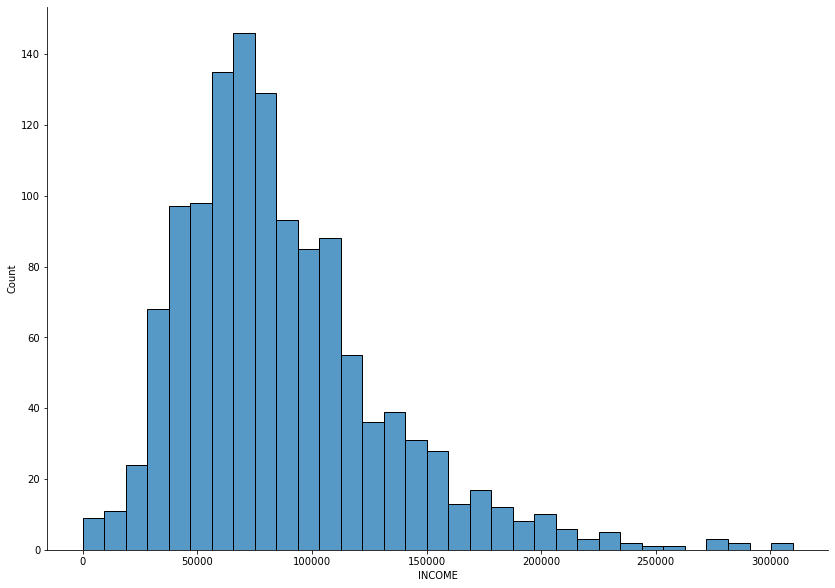

In [97]:
sb.displot(manager, x="INCOME", height=8.27, aspect=11.7/8.27)

##### Professional

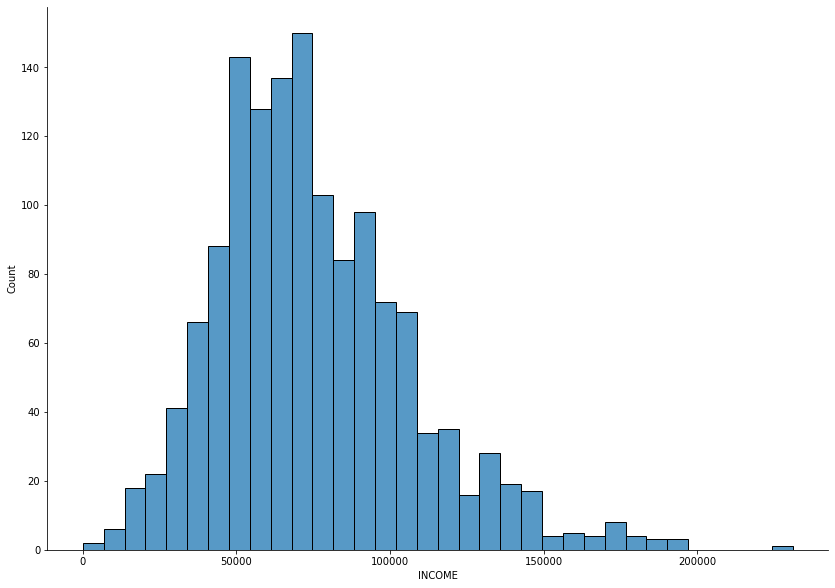

In [98]:
sb.displot(professional, x="INCOME", height=8.27, aspect=11.7/8.27)

##### Blue Collar

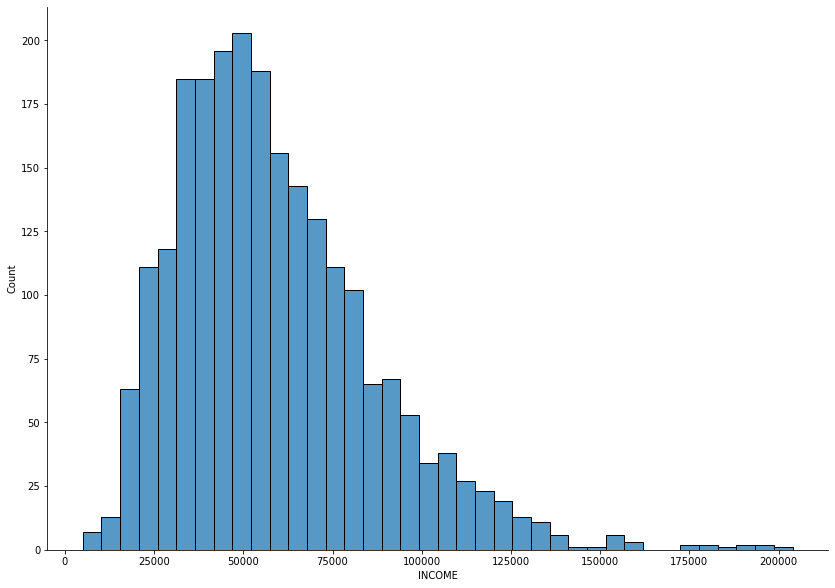

In [99]:
sb.displot(blue_collar, x="INCOME", height=8.27, aspect=11.7/8.27)

##### Clerical

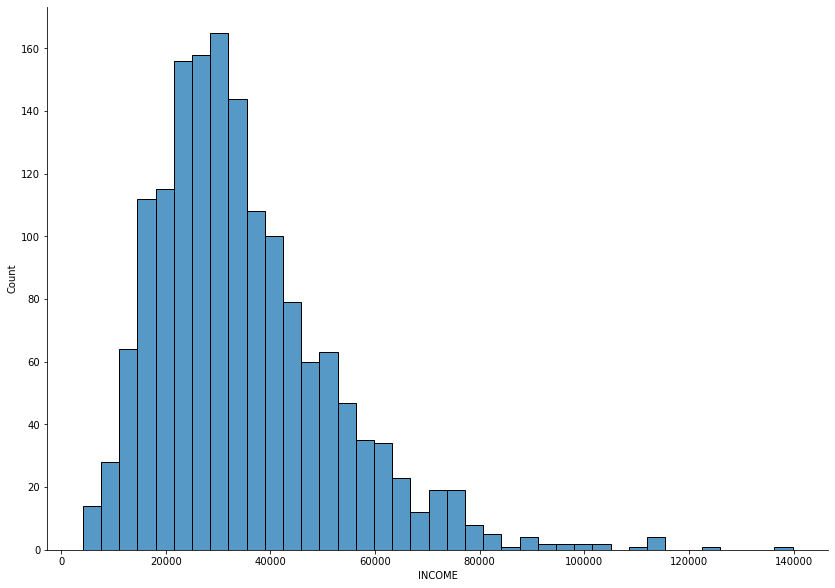

In [100]:
sb.displot(clerical, x="INCOME", height=8.27, aspect=11.7/8.27)

##### Home Maker

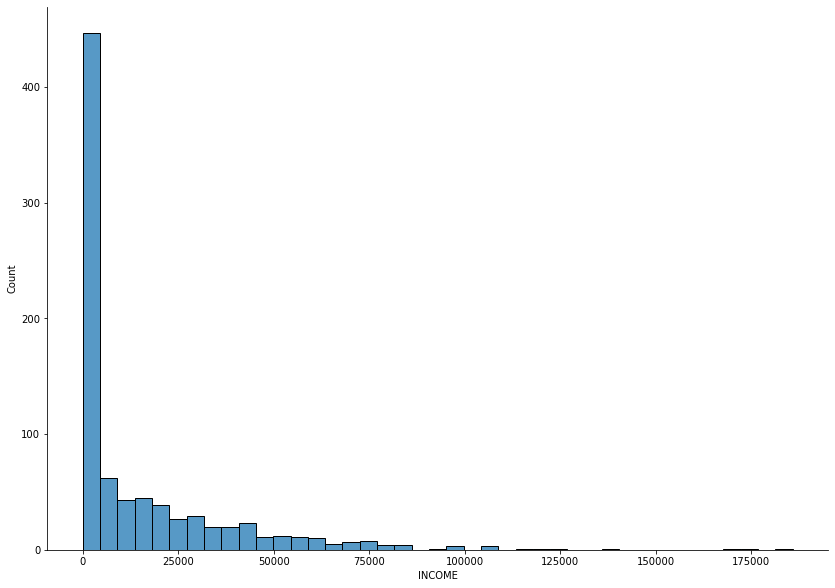

In [101]:
sb.displot(home_maker, x="INCOME", height=8.27, aspect=11.7/8.27)

##### Student

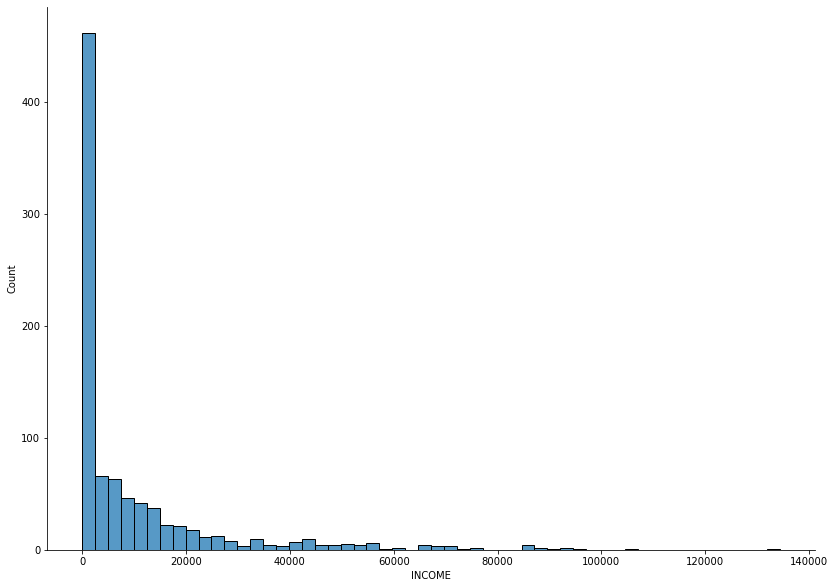

In [102]:
sb.displot(student, x="INCOME", height=8.27, aspect=11.7/8.27)

Teraz dla każdego wiersza trzeba porównać zarobki ze średnimi zarobkami w danym zawodzie, to znaczy znaleźć średnią dla takiego zawodu, której wartość zarobków w danym wierszu będzie najbliższa.

In [103]:
for i in range(0, nan.shape[0]):
    closest = closest_value(means, nan.iloc[i]["INCOME"])
    if closest == mean_professional:
        nan.iloc[i,11] = "Professional" #11, bo zmienna OCCUPATION jest w 11. kolumnie
    elif closest == mean_blue_collar:
        nan.iloc[i,11] = "Blue Collar"
    elif closest == mean_manager:
        nan.iloc[i,11] = "Manager"
    elif closest == mean_clerical:
        nan.iloc[i,11] = "Clerical"
    elif closest == mean_doctor:
        nan.iloc[i,11] = "Doctor"
    elif closest == mean_lawyer:
        nan.iloc[i,11] = "Lawyer"
    elif closest == mean_home_maker:
        nan.iloc[i,11] = "Home Maker"
    elif closest == mean_student:
        nan.iloc[i,11] = "Student"

C:\Users\lnaklicki001\Documents\Anaconda\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Teraz można zamienić kolumnę ze zmienną OCCUPATION w głównym zestawie danych na kolumnę zapasową, na której dokonano imputacji

In [104]:
df.dropna(inplace=True)
df = df.append(nan)
df = df.sort_index()

Wszystkie braki powinny być już w tym momencie zapełnione. Można to sprawdzić:

In [105]:
df.isnull().sum()

ID            0
KIDSDRIV      0
AGE           0
HOMEKIDS      0
YOJ           0
INCOME        0
PARENT1       0
HOME_VAL      0
MSTATUS       0
GENDER        0
EDUCATION     0
OCCUPATION    0
TRAVTIME      0
CAR_USE       0
BLUEBOOK      0
TIF           0
CAR_TYPE      0
RED_CAR       0
OLDCLAIM      0
CLM_FREQ      0
REVOKED       0
MVR_PTS       0
CLM_AMT       0
CAR_AGE       0
CLAIM_FLAG    0
URBANICITY    0
OG_DATA       0
dtype: int64

Zgadza się, wszystkie braki w danych zostały pomyślnie zaimputowane.

In [106]:
df.head()

,ID,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,...,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY,OG_DATA
0,63581743.0,0.0,60.0,0.0,11.0,67349.0,False,0.0,False,M,...,True,4461.0,2.0,False,3.0,0.0,18.0,False,Highly Urban/ Urban,1.0
1,132761049.0,0.0,43.0,0.0,11.0,91449.0,False,257252.0,False,M,...,True,0.0,0.0,False,0.0,0.0,1.0,False,Highly Urban/ Urban,1.0
2,921317019.0,0.0,48.0,0.0,11.0,52881.0,False,0.0,False,M,...,True,0.0,0.0,False,2.0,0.0,10.0,False,Highly Urban/ Urban,1.0
3,727598473.0,0.0,35.0,1.0,10.0,16039.0,False,124191.0,True,F,...,False,38690.0,2.0,False,3.0,0.0,10.0,False,Highly Urban/ Urban,1.0
4,450221861.0,0.0,51.0,0.0,14.0,146247.2,False,306251.0,True,M,...,True,0.0,0.0,False,0.0,0.0,6.0,False,Highly Urban/ Urban,0.0


### Sprawdzenie, czy korelacje nie uległy zmianie po imputacji

##### Korelacja pomiędzy zmiennymi zawierającymi braki a resztą zmiennych przed imputacją

In [389]:
numeric_cols_old = []
for c in stare_df.columns[1:]:
    if str(stare_df.loc[:, c].dtype) not in ['category', 'bool']:
        numeric_cols_old.append(c)
        
stare_df['INCOME'].astype('float64')

korelacja_stara = pd.DataFrame()
columns=['INCOME','AGE','CAR_AGE','YOJ','OCCUPATION','HOME_VAL']
for column in columns:
    korelacja_stara[column] = stare_df[column]

correl = pd.DataFrame()
for column in korelacja_stara.drop(columns='OCCUPATION').columns:
    correl[column] = stare_df[numeric_cols_old].corr()[column]
correl

,INCOME,AGE,CAR_AGE,YOJ,HOME_VAL
KIDSDRIV,-0.043217,-0.078427,-0.059674,0.042971,-0.015447
AGE,0.186202,1.000000,0.178648,0.140878,0.209600
HOMEKIDS,-0.160230,-0.447787,-0.159103,0.077707,-0.107483
YOJ,0.293899,0.140878,0.064738,1.000000,0.272198
INCOME,1.000000,0.186202,0.417340,0.293899,0.578943
HOME_VAL,0.578943,0.209600,0.223286,0.272198,1.000000
TRAVTIME,-0.051853,-0.001569,-0.033209,-0.017152,-0.035139
BLUEBOOK,0.429095,0.166290,0.194393,0.148086,0.261962
TIF,0.002361,-0.001890,0.007863,0.023921,0.006768
OLDCLAIM,-0.039347,-0.033378,-0.018800,-0.005077,-0.059803


##### Korelacja pomiędzy zmiennymi zawierającymi braki a resztą zmiennych po imputacji

In [390]:
numeric_cols = []
for c in df.columns[1:]:
    if str(df.loc[:, c].dtype) not in ['category', 'bool']:
        numeric_cols.append(c)
korelacja = pd.DataFrame()
columns=['INCOME','AGE','CAR_AGE','YOJ','OCCUPATION','HOME_VAL']
for column in columns:
    korelacja[column] = df[column]
correll = pd.DataFrame()

for column in korelacja.drop(columns='OCCUPATION').columns:
    correll[column] = df[numeric_cols].drop(columns='OG_DATA').corr()[column]
correll

,INCOME,AGE,CAR_AGE,YOJ,HOME_VAL
KIDSDRIV,-0.043925,-0.078427,-0.056548,0.040055,-0.015247
AGE,0.180820,1.000000,0.171841,0.134588,0.203764
HOMEKIDS,-0.155729,-0.447787,-0.151492,0.075182,-0.102659
YOJ,0.278395,0.134588,0.062606,1.000000,0.257936
INCOME,1.000000,0.180820,0.391636,0.278395,0.546175
HOME_VAL,0.546175,0.203764,0.210879,0.257936,1.000000
TRAVTIME,-0.051788,-0.001569,-0.031090,-0.016072,-0.034641
BLUEBOOK,0.416794,0.166290,0.185740,0.143172,0.251832
TIF,0.002056,-0.001890,0.008990,0.023353,0.007454
OLDCLAIM,-0.038002,-0.033378,-0.018988,-0.005000,-0.060266


Wniosek: korelacje nie zmieniły się znacząco po imputacji.

##### Statystyki opisowe przed imputacjami

In [159]:
korelacja_stara.describe()

,INCOME,AGE,CAR_AGE,YOJ,HOME_VAL
count,9732.000000,10295.000000,9663.000000,9754.000000,9727.000000
mean,61572.136719,44.837397,8.298768,10.474062,154522.828125
std,47457.460938,8.606445,5.713548,4.108943,129186.617188
min,0.000000,16.000000,0.000000,0.000000,0.000000
25%,27584.000000,39.000000,1.000000,9.000000,0.000000
50%,53529.000000,45.000000,8.000000,11.000000,160661.000000
75%,86166.000000,51.000000,12.000000,13.000000,238256.000000
max,367030.000000,81.000000,28.000000,23.000000,885282.000000


##### Statystyki opisowe po imputacjach

In [317]:
korelacja.describe()

,INCOME,AGE,CAR_AGE,YOJ,HOME_VAL
count,10295.000000,10295.000000,10295.000000,10295.000000,10295.000000
mean,61405.269840,44.837397,8.291559,10.470753,154521.636309
std,46442.957737,8.606445,5.577794,4.023806,126392.044882
min,0.000000,16.000000,0.000000,0.000000,0.000000
25%,28722.000000,39.000000,3.000000,9.000000,0.000000
50%,53739.000000,45.000000,8.000000,11.000000,159782.000000
75%,84621.500000,51.000000,12.000000,13.000000,234997.000000
max,367030.000000,81.000000,28.000000,23.000000,885282.000000


### Sprawdzenie rozkładów zmiennych po imputacji

##### 1a) AGE przed imputacjami

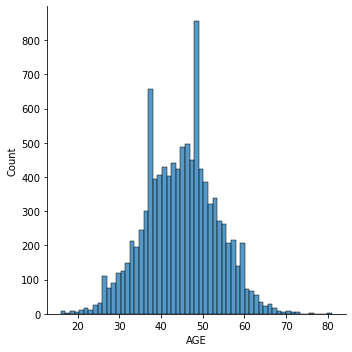

In [161]:
sb.displot(stare_df, x="AGE")

##### 1b) AGE po imputacjach

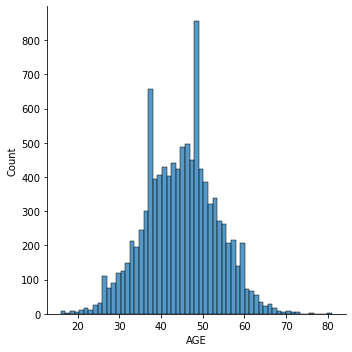

In [162]:
sb.displot(df, x="AGE")

##### 2a) YOJ przed imputacjami

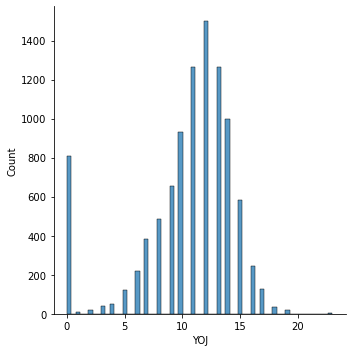

In [167]:
sb.displot(stare_df, x="YOJ")

##### 2b) YOJ po imputacjach

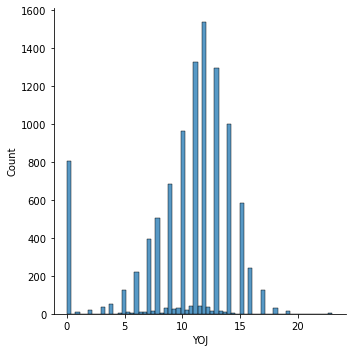

In [168]:
sb.displot(df, x="YOJ")

##### 3a) INCOME przed imputacjami

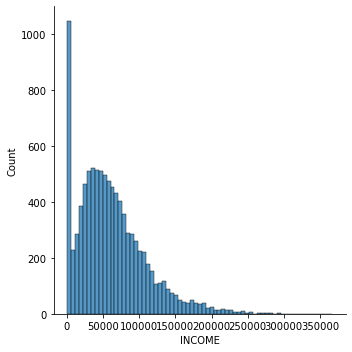

In [173]:
sb.displot(stare_df, x="INCOME")

##### 3b) INCOME po imputacjach

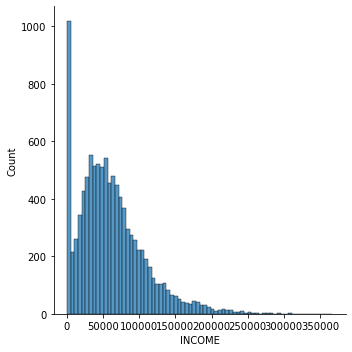

In [174]:
sb.displot(df, x="INCOME")

##### 4a) HOME_VAL przed imputacjami

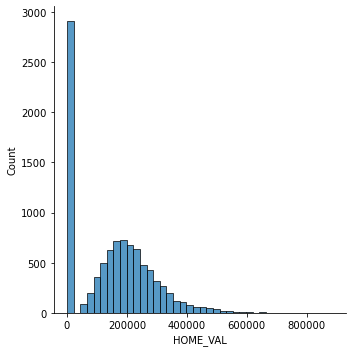

In [185]:
sb.displot(stare_df, x="HOME_VAL")

##### 4b) HOME_VAL po imputacjach

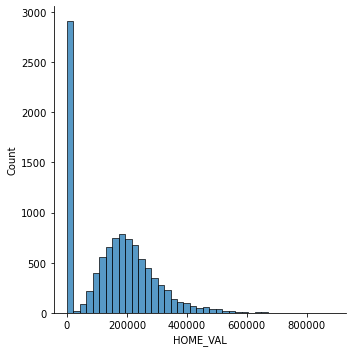

In [186]:
sb.displot(df, x="HOME_VAL")

##### 5a) CAR_AGE przed imputacjami

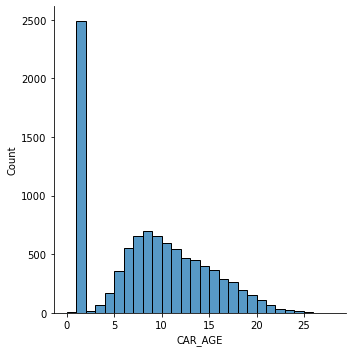

In [234]:
sb.displot(stare_df, x="CAR_AGE")

##### 5b) CAR_AGE po imputacjach

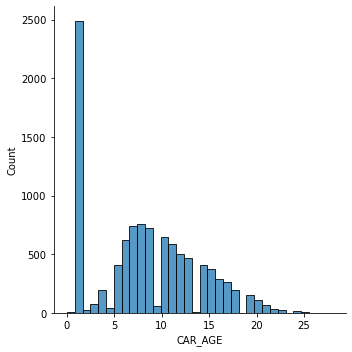

In [233]:
sb.displot(df, x="CAR_AGE")

### Porównanie średnich wartości i odchylenia standardowego kolumn z imputacjami przed i po imputacji

In [235]:
stare_srednie = []
nowe_srednie = []
stare_odch = []
nowe_odch = []

porownanie_help = korelacja.drop(columns='OCCUPATION')
for column in porownanie_help.columns:
    stare_srednie.append(stare_df[column].mean())
    nowe_srednie.append(df[column].mean())
    stare_odch.append(stare_df[column].std())
    nowe_odch.append(df[column].std())

porownanie = pd.DataFrame()
porownanie['OLD_MEAN'] = stare_srednie
porownanie['NEW_MEAN'] = nowe_srednie
porownanie["OLD_ST_DEVIATION"] = stare_odch
porownanie["NEW_ST_DEVIATION"] = nowe_odch

porownanie.rename(index={0:'INCOME', 1:'AGE', 2:'CAR_AGE', 3:'YOJ', 4:'HOME_VAL'})

,OLD_MEAN,NEW_MEAN,OLD_ST_DEVIATION,NEW_ST_DEVIATION
INCOME,61572.136719,61405.269840,47457.460938,46442.957737
AGE,44.837397,44.837397,8.606445,8.606445
CAR_AGE,8.298768,8.291559,5.713548,5.577794
YOJ,10.474062,10.470753,4.108943,4.023806
HOME_VAL,154522.828125,154521.636309,129186.617188,126392.044882
